In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime
import scipy
import importlib
import os, sys
import seaborn as sns
import tqdm
from pandas_datareader import data
import networkx as nx
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, DotProduct, ExpSineSquared, WhiteKernel

In [2]:
np.array(pd.DataFrame(np.array([[1,0.3], [2,0.3]])).corr())

array([[ 1., nan],
       [nan, nan]])

In [8]:
def score_log(estimator, X, y):

    y_pred, std_prediction = estimator.predict(X, return_std=True)

    return np.sum(-0.5*np.log(std_prediction) - (y_pred - y) ** 2 / std_prediction**2)



def fit_gp_cv(kernel, X_obs, y_obs, X_pred, scale = True):

    from sklearn.model_selection import RandomizedSearchCV

    # Create CV
    index = np.array(range(y_obs.shape[0]))
    cv = list()
    for i in [0,1,2,3]:
        test = index[i:len(index):4]
        train = index[~np.isin(index,test)]
        cv.append((train, test))

    # rs = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)
    distributions = dict(alpha=np.linspace(0.001, 0.3, 120))# dict(alpha=uniform(loc = 0, scale = 0.5))

    clf = RandomizedSearchCV(gaussian_process.GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer=30, normalize_y= scale),
                                                                         distributions, random_state=0, cv = cv, n_iter  = 120)
    search = clf.fit(X_obs, y_obs)
    gp = gaussian_process.GaussianProcessRegressor(kernel=kernel,normalize_y = scale, n_restarts_optimizer=30, alpha =  search.best_params_['alpha']).fit(X_obs, y_obs)

    mean_prediction, std_prediction = gp.predict(X_pred, return_std=True)

    return mean_prediction, std_prediction,  gp, search



def fit_and_print(kernel_tests, X_obs, y_obs):

    for idx in range(len(kernel_tests)): 
        gp = gaussian_process.GaussianProcessRegressor(kernel=kernel_tests[idx], n_restarts_optimizer=50)
        out_gp = gp.fit(X_obs, y_obs)
        print(f'{out_gp.kernel_} {out_gp.log_marginal_likelihood()}')


def plot_fit(gp, X_obs, y_obs):
    X = np.linspace(X_obs[0], X_obs[-1], 500)
    mean_prediction, std_prediction = gp.predict(X, return_std=True)


    fig, ax = plt.subplots(1,1, figsize = (20,10))
    #plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
    ax.scatter(X_obs, y_obs, label="Observations")
    ax.plot(X, mean_prediction, label="Mean prediction")
    ax.fill_between(
        X.ravel(),
        mean_prediction - 1.96 * std_prediction,
        mean_prediction + 1.96 * std_prediction,
        alpha=0.5,
        label=r"95% confidence interval",
    )
    ax.legend()
    ax.set_xlabel("$x$")
    ax.set_ylabel("$f(x)$")
    ax.set_title(f"{gp.kernel_}")


def plot_gp_search(search_out, horizontal_size = 5):

    k = len(search_out)
    if k<3:
        k = 3
    fig, ax = plt.subplots( int(k/3)+1 , 3, figsize = (40 ,horizontal_size*(int(k/3)+1)))
        

    for idx, sector in enumerate(search_out.keys()):

        j = idx % 3
        i = int(np.floor(idx/3))

        ax[i,j].scatter(search_out[sector].cv_results_['param_alpha'], search_out[sector].cv_results_['mean_test_score'])
        ax[i,j].set_title(f'{sector}')

def plot_gp_fit_sector(sector_esg,sector_esg_index, sector_gp, sector_gp_std, sector_gp_out,horizontal_size = 5):

    k = sector_gp.shape[1]
    if k<3:
        k = 3
    
    fig, ax = plt.subplots( int(k/3)+1 , 3, figsize = (40 ,horizontal_size*(int(k/3)+1)))
            

    for idx, sector in enumerate(sector_gp.columns):

        j = idx % 3
        i = int(np.floor(idx/3))
        y_obs = np.array(sector_esg[sector].copy())
        y_obs[~sector_esg_index[sector]] = np.nan
        ax[i,j].plot(sector_gp.index, sector_gp[sector], label = i)
        ax[i,j].scatter(sector_esg.index, y_obs, label = i)

        ax[i,j].fill_between(
        sector_gp.index,
        sector_gp[sector] - 1.96 * sector_gp_std[sector],
        sector_gp[sector] + 1.96 * sector_gp_std[sector],
        alpha=0.5,
        label=r"95% confidence interval",
    )
        ax[i,j].set_title(f'{sector}, {sector_gp_out[sector].kernel_}')


def opt_all_col(data, index, kernel = 1*Matern(length_scale=1, nu = 1.5)):
    sector_gp = dict()
    sector_gp_std = dict()
    sector_gp_out = dict()
    search_out = dict()
    for sector in data.columns:
        print(sector)

        X = np.array(range(len(data.index)))
        y = np.array(data[sector])

        y_obs = y[index[sector]]
        X_obs = np.expand_dims(X[index[sector]], axis = 1)
        X = np.expand_dims(X, axis=1)

        X_pred = np.expand_dims(np.array(range(X.shape[0])), axis = 1)
        mean_prediction, std_prediction,  gp, search = fit_gp_cv(kernel, X_obs, y_obs, X_pred)

        print(search.best_params_)

        sector_gp[sector] = mean_prediction
        sector_gp_std[sector] = std_prediction
        sector_gp_out[sector] = gp
        search_out[sector] = search


    sector_gp = pd.DataFrame(sector_gp, index = data.index)
    sector_gp_std = pd.DataFrame(sector_gp_std, index = data.index)

    return sector_gp, sector_gp_std, sector_gp_out, search_out





    #return pd.DataFrame(corr_diag)



def abs_graph(corrs, threshold):

    corrs_new = []
    for i in range(len(corrs)):

        corrs_new.append(np.abs(corrs[i].copy()))


        corrs_new[i][corrs_new[i] < threshold] = 0

    
    return corrs_new
    


# Sector Index

load data

Text(0, 0.5, 'ESG Score')

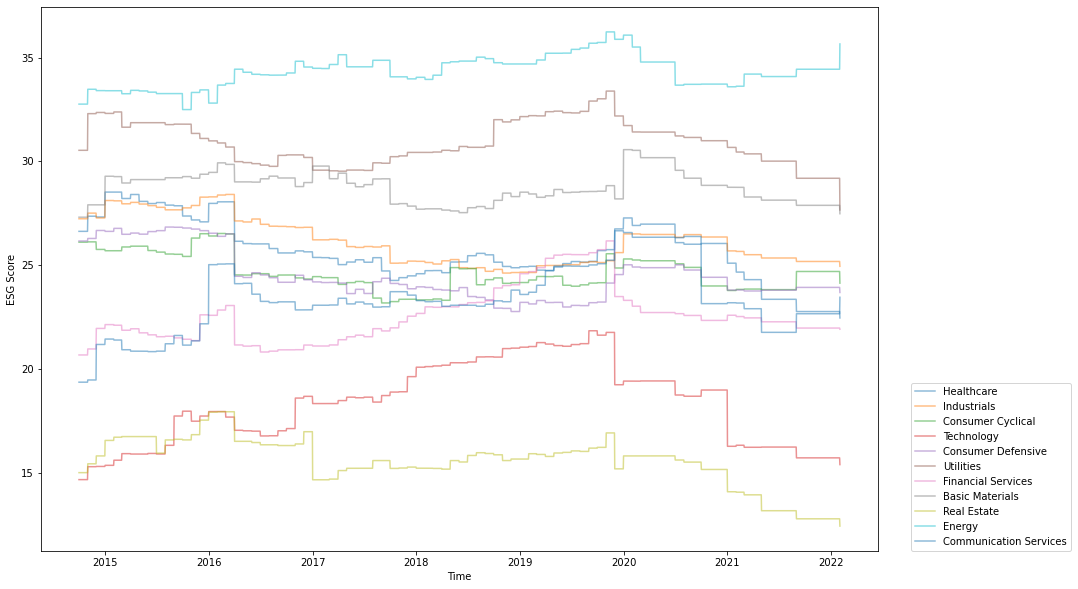

In [4]:
sector_esg_dict = pd.read_pickle('../Yahoo/sector_index_no_diff.pkl')
sector_esg = sector_esg_dict['data']
sector_esg_index = sector_esg_dict['index']
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
for sector in sector_esg.columns:

    y = sector_esg[sector].fillna(method='ffill')

    out = ax.plot(sector_esg.index, y, alpha = 0.5, label = sector)
    # legend_ticks.append(sector)

ax.legend(loc=(1.04,0))
ax.set_xlabel("Time")
ax.set_ylabel("ESG Score")

11.4**2 * Matern(length_scale=1.38e+03, nu=1.5)
-62.27185909427538
0.9373209913189446


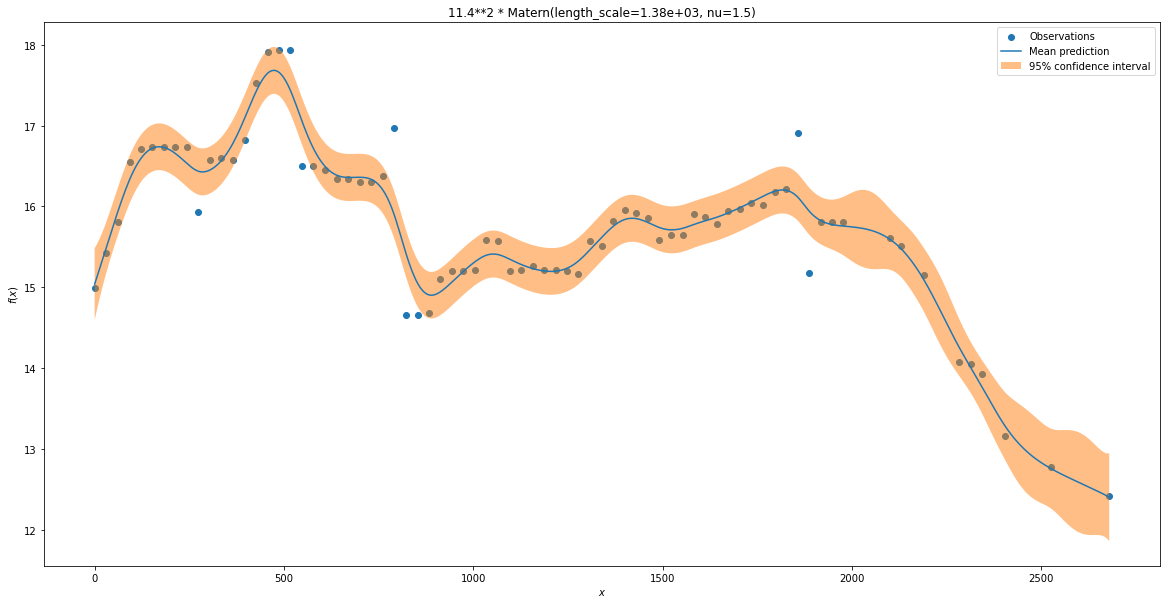

In [272]:
sector = 'Real Estate'
X = np.array(range(len(sector_esg.index)))
y = np.array(sector_esg[sector])

y_obs = y[sector_esg_index[sector]]
X_obs = np.expand_dims(X[sector_esg_index[sector]], axis = 1)
X = np.expand_dims(X, axis=1)

gp = gaussian_process.GaussianProcessRegressor(kernel=1*Matern(length_scale=1, nu = 1.5), n_restarts_optimizer=50, alpha = 0.08).fit(X_obs, y_obs)
print(gp.kernel_)
print(gp.log_marginal_likelihood_value_)
print(gp.score(X_obs, y_obs))
plot_fit(gp, X_obs, y_obs)

In [267]:
sector = 'Basic Materials'
print(sector)

X = np.array(range(len(sector_esg.index)))
y = np.array(sector_esg[sector])

y_obs = y[sector_esg_index[sector]]
X_obs = np.expand_dims(X[sector_esg_index[sector]], axis = 1)
X = np.expand_dims(X, axis=1)


kernel = 1*Matern(length_scale=1, nu = 1.5)#1*RBF(length_scale=1)# 1*Matern(length_scale=1, nu = 1.5)
X_pred = np.expand_dims(np.array(range(X.shape[0])), axis = 1)
mean_prediction, std_prediction,  gp, search = fit_gp_cv(kernel, X_obs, y_obs, X_pred)

ok = pd.DataFrame(search.cv_results_)
plt.scatter(ok['param_alpha'], ok['mean_test_score'])
ok 


Basic Materials


KeyboardInterrupt: 

1.03**2 * Matern(length_scale=142, nu=1.5)
-69.05117035148939
0.9230268670457673


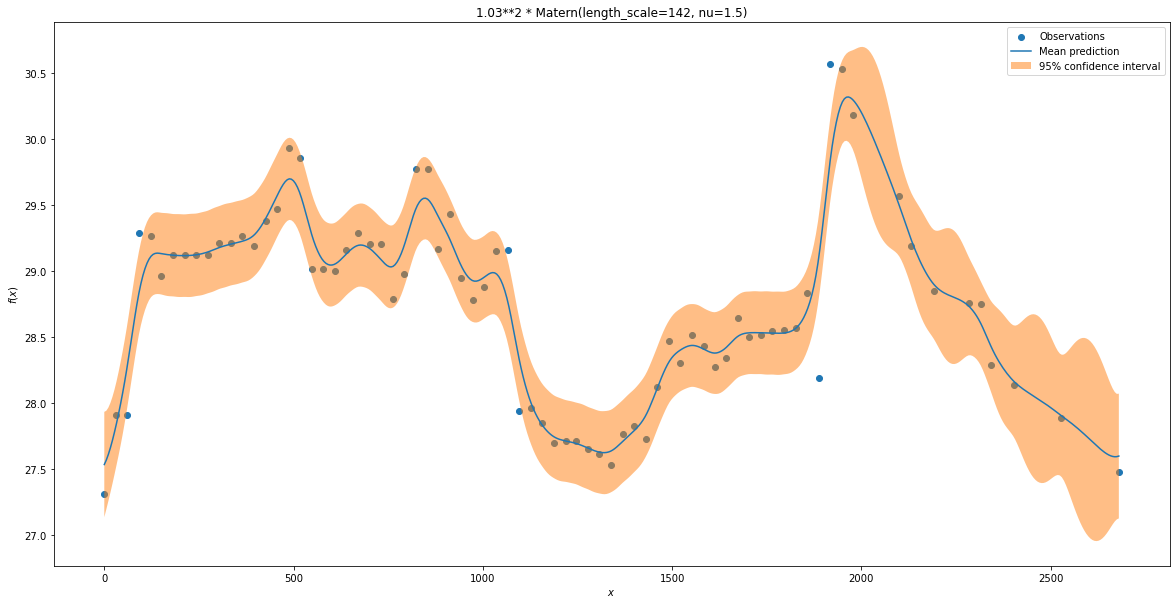

In [156]:

gp = gaussian_process.GaussianProcessRegressor(kernel=kernel, normalize_y = True, n_restarts_optimizer=20, alpha = search.best_params_['alpha']).fit(X_obs, y_obs)
print(gp.kernel_)
print(gp.log_marginal_likelihood_value_)
print(gp.score(X_obs, y_obs))
plot_fit(gp, X_obs, y_obs)

In [133]:
std_best = np.array(ok['std_test_score'].loc[ok['rank_test_score'] == 1])[0]
score_best = np.array(ok['mean_test_score'].loc[ok['rank_test_score'] == 1])[0]


max_margin = np.max(ok['param_alpha'].loc[ok['mean_test_score'] > score_best - std_best])
max_margin
search.best_params_['alpha']

0.122010101010101

1.35**2 * Matern(length_scale=298, nu=1.5)
-53.729299856155805
0.9320118441875903


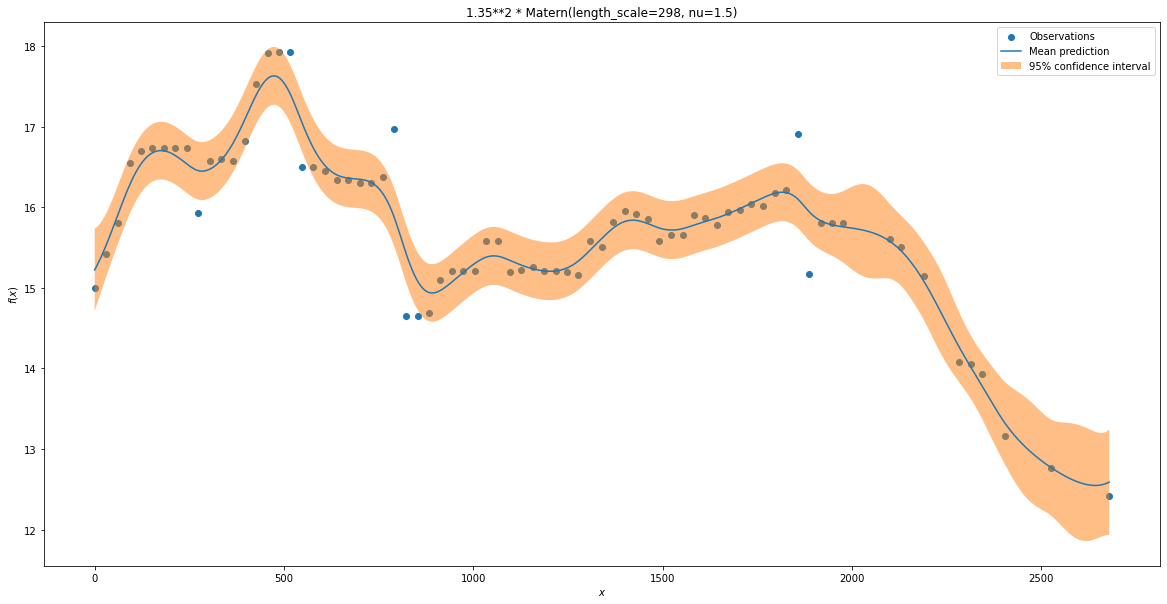

In [275]:
kernel = 1*Matern(length_scale=1, nu = 1.5)
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel, normalize_y = True, n_restarts_optimizer=20, alpha = search.best_params_['alpha']).fit(X_obs, y_obs)
print(gp.kernel_)
print(gp.log_marginal_likelihood_value_)
print(gp.score(X_obs, y_obs))
plot_fit(gp, X_obs, y_obs)

# Optimize for all sectors

In [5]:
sector_gp, sector_gp_std, sector_gp_out, search_out = opt_all_col(sector_esg, sector_esg_index, kernel=1 * Matern(length_scale= 1, nu = 1.5))

Healthcare
{'alpha': 0.018588235294117645}
Industrials
{'alpha': 0.011050420168067225}
Consumer Cyclical
{'alpha': 0.056277310924369744}
Technology
{'alpha': 0.013563025210084033}
Consumer Defensive
{'alpha': 0.013563025210084033}
Utilities
{'alpha': 0.04622689075630252}
Financial Services
{'alpha': 0.028638655462184873}
Basic Materials
{'alpha': 0.12411764705882351}
Real Estate
{'alpha': 0.06884033613445377}
Energy
{'alpha': 0.05376470588235294}
Communication Services
{'alpha': 0.018588235294117645}


In [280]:
sector_gp_m_25, sector_gp_std_m_25, sector_gp_out_m_25, search_out_m_25 = opt_all_col(sector_esg, sector_esg_index, kernel=1 * Matern(length_scale= 1, nu = 2.5))

Healthcare
{'alpha': 0.021100840336134453}
Industrials
{'alpha': 0.013563025210084033}
Consumer Cyclical
{'alpha': 0.056277310924369744}
Technology
{'alpha': 0.01607563025210084}
Consumer Defensive
{'alpha': 0.011050420168067225}
Utilities
{'alpha': 0.056277310924369744}
Financial Services
{'alpha': 0.028638655462184873}
Basic Materials
{'alpha': 0.12663025210084033}
Real Estate
{'alpha': 0.07386554621848739}
Energy
{'alpha': 0.06632773109243698}
Communication Services
{'alpha': 0.018588235294117645}


In [281]:
for k in sector_gp_out.keys():

    print(f'{k}, nu1.5: {sector_gp_out[k].log_marginal_likelihood_value_}, nu2.5: {sector_gp_out_m_25[k].log_marginal_likelihood_value_}')


Healthcare, nu1.5: -19.127544115183518, nu2.5: -21.47654103824
Industrials, nu1.5: -3.9726879832859368, nu2.5: -6.967713124211798
Consumer Cyclical, nu1.5: -51.30045757833918, nu2.5: -52.22877024197644
Technology, nu1.5: -8.661188774105213, nu2.5: -11.602491023609062
Consumer Defensive, nu1.5: -11.231511980397116, nu2.5: -16.883981255045384
Utilities, nu1.5: -30.314601123118607, nu2.5: -32.147922020056754
Financial Services, nu1.5: -26.835916573207975, nu2.5: -28.3686361470237
Basic Materials, nu1.5: -69.05117035148939, nu2.5: -69.77559945976964
Real Estate, nu1.5: -52.68300068449362, nu2.5: -53.85211777029819
Energy, nu1.5: -41.87593876272893, nu2.5: -41.67604725647648
Communication Services, nu1.5: -32.51825729028861, nu2.5: -33.273478471444015


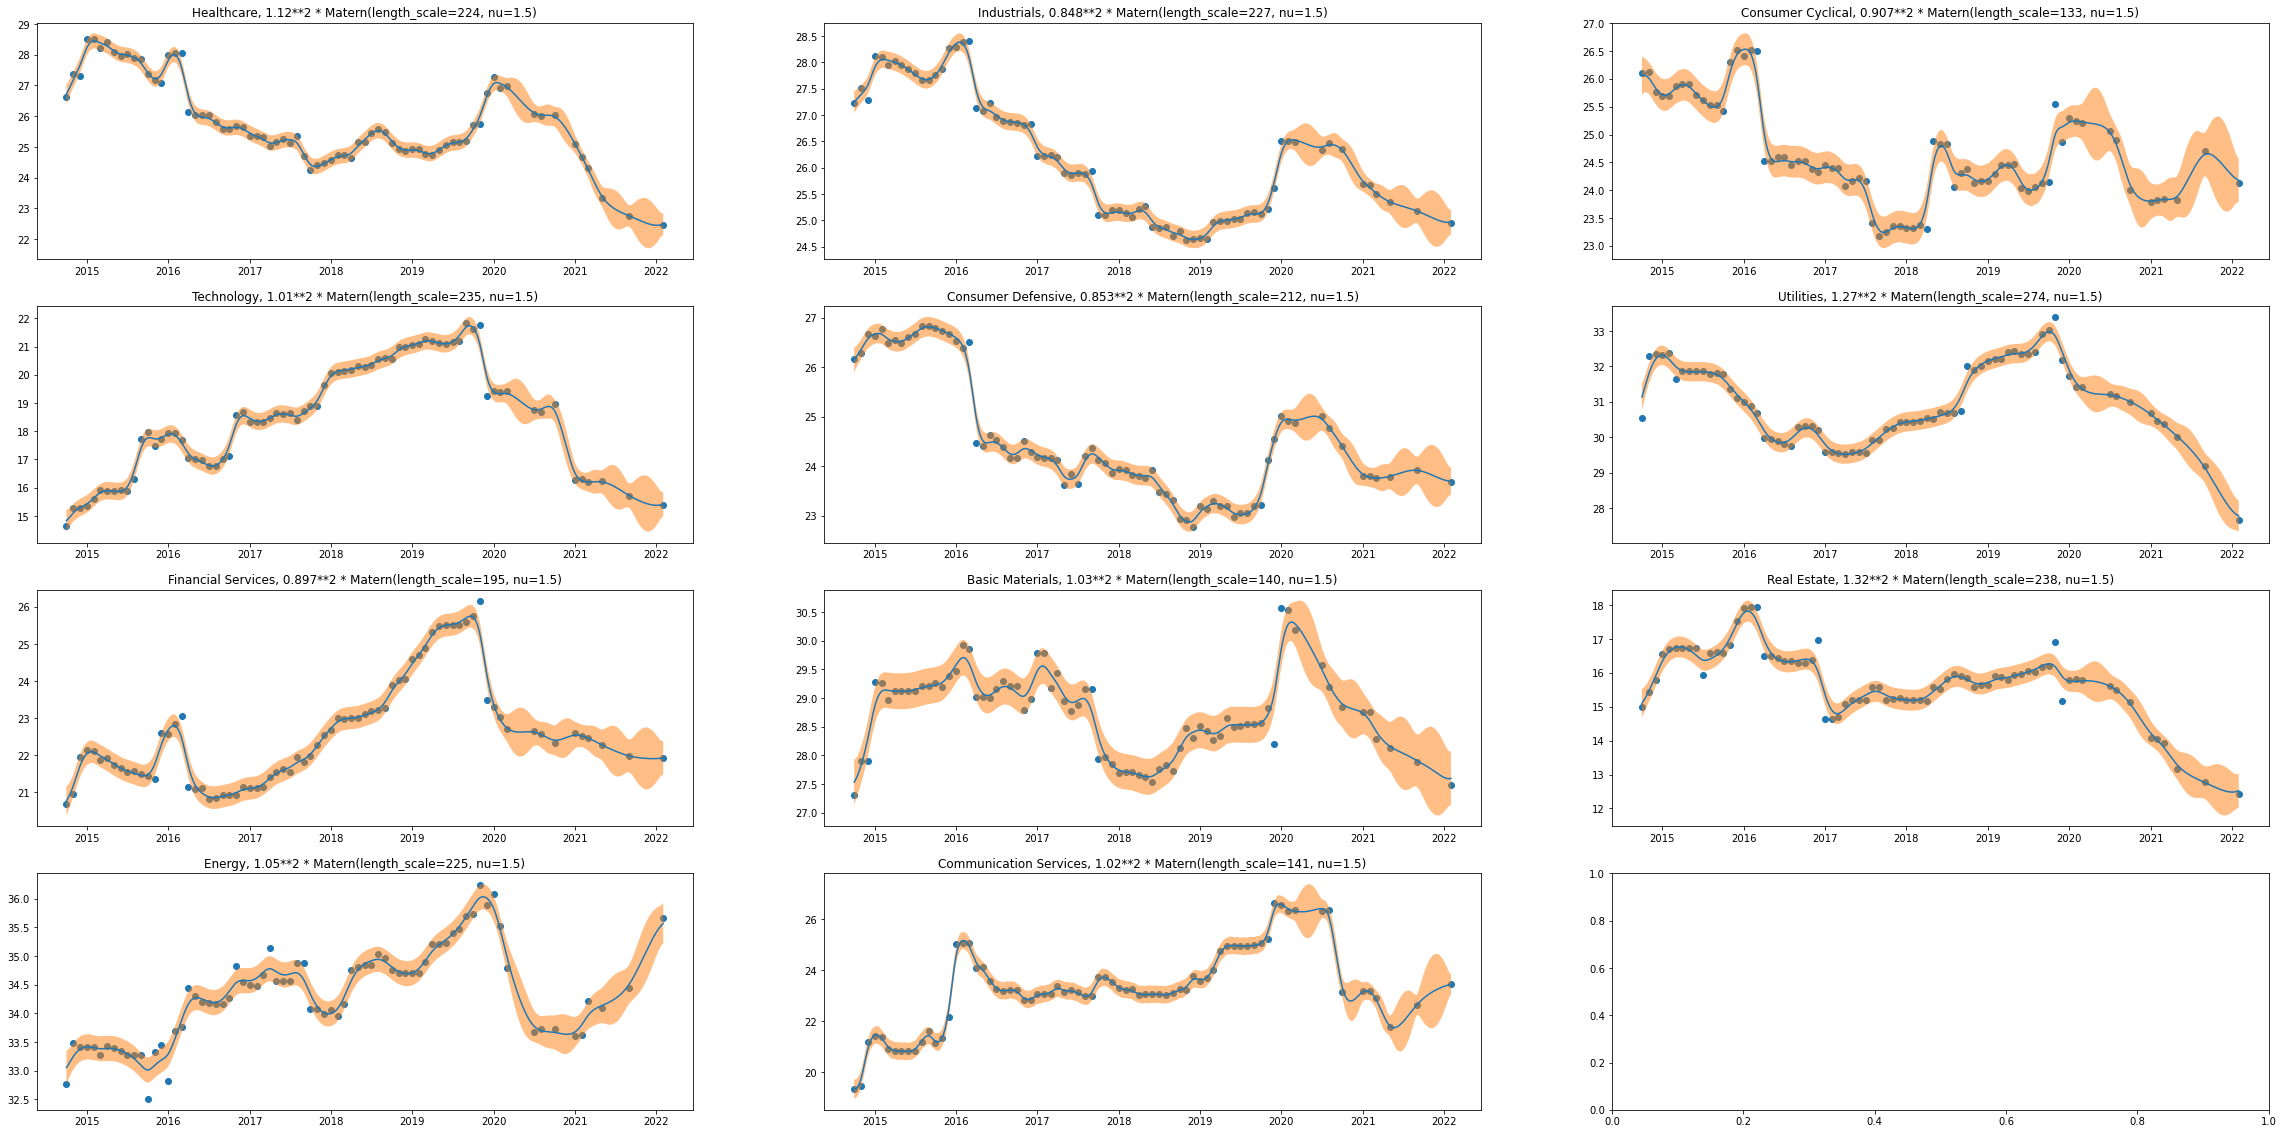

In [10]:
plot_gp_fit_sector(sector_esg,sector_esg_index, sector_gp, sector_gp_std, sector_gp_out)

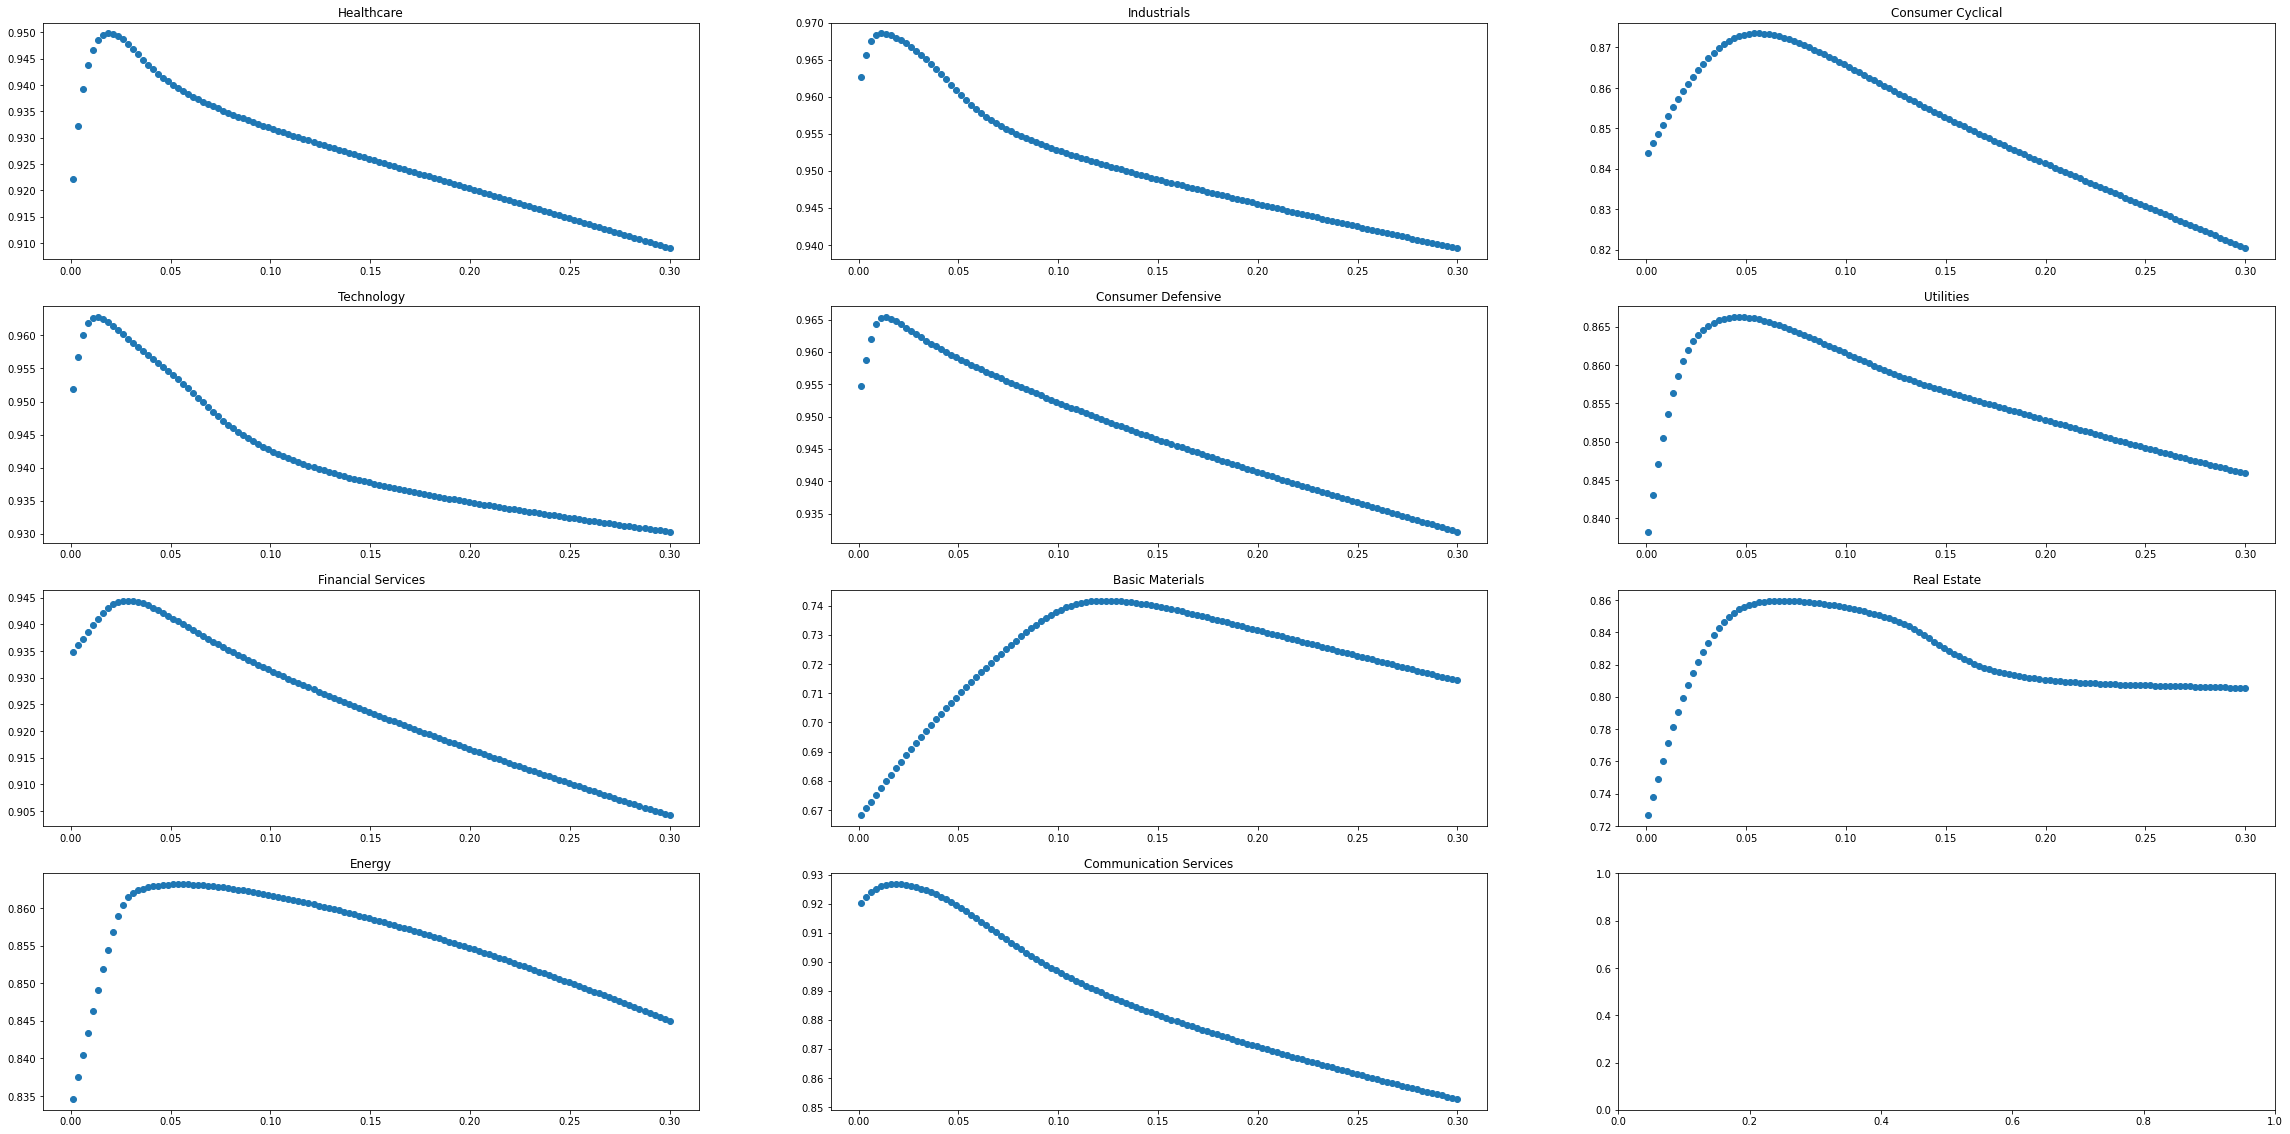

In [11]:
plot_gp_search(search_out)

In [12]:
sector_gp.to_pickle('../Yahoo/sector_gp.pkl')

# Industrial

In [177]:
Industrial_dict = pd.read_pickle('../Yahoo/Industrial_Industry.pkl')
Industrial_esg = Industrial_dict['data']
Industrial_esg_index = Industrial_dict['index']
industrial_gp, industrial_gp_std, industrial_gp_out, industrial_search_out = opt_all_col(Industrial_esg, Industrial_esg_index)

Aerospace & Defense
{'alpha': 0.025181818181818187}
Airlines
{'alpha': 0.021151515151515154}
Building Products & Equipment
{'alpha': 0.06145454545454546}
Business Equipment & Supplies
{'alpha': 0.05742424242424243}
Conglomerates
{'alpha': 0.04130303030303031}
Consulting Services
{'alpha': 0.005030303030303031}
Engineering & Construction
{'alpha': 0.021151515151515154}
Farm & Heavy Construction Machinery
{'alpha': 0.05742424242424243}
Industrial Distribution
{'alpha': 0.03324242424242425}
Integrated Freight & Logistics
{'alpha': 0.00906060606060606}
Railroads
{'alpha': 0.005030303030303031}
Rental & Leasing Services
{'alpha': 0.001}
Security & Protection Services
{'alpha': 0.017121212121212124}
Specialty Business Services
{'alpha': 0.08160606060606061}
Specialty Industrial Machinery
{'alpha': 0.22266666666666668}
Staffing & Employment Services
{'alpha': 0.00906060606060606}
Tools & Accessories
{'alpha': 0.04936363636363637}
Waste Management
{'alpha': 0.04533333333333334}


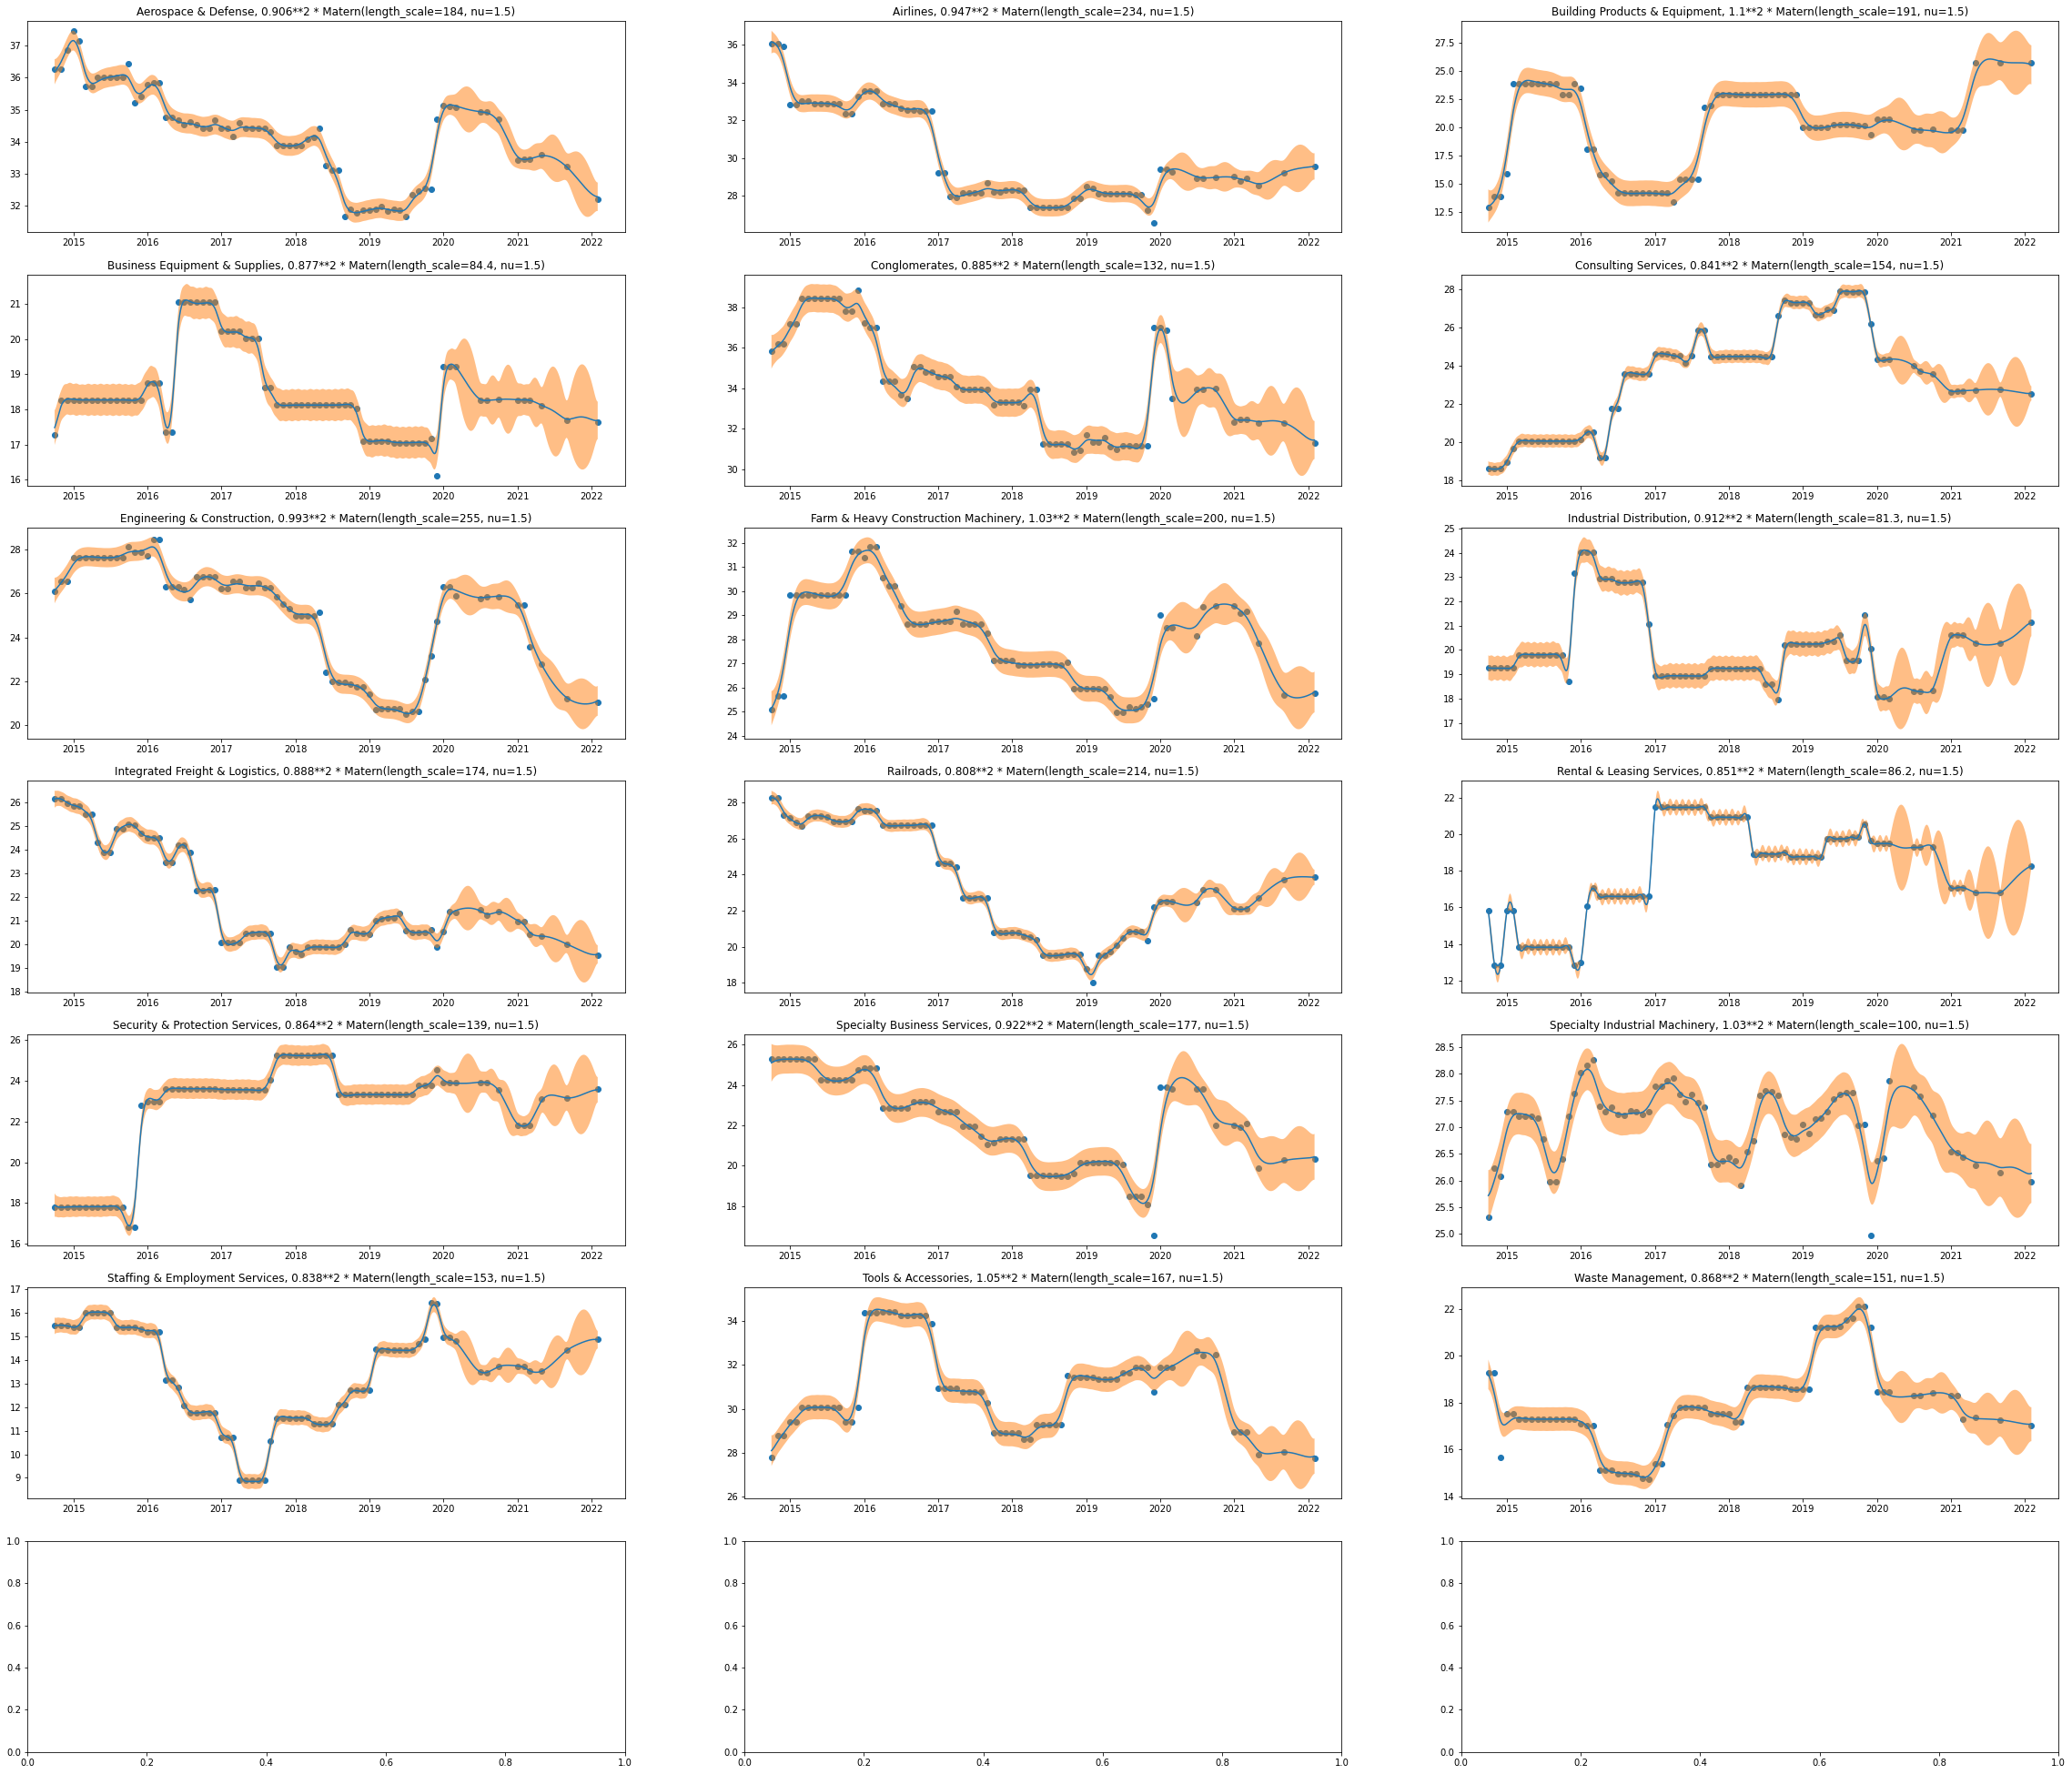

In [189]:
plot_gp_fit_sector(Industrial_esg,Industrial_esg_index, industrial_gp, industrial_gp_std, industrial_gp_out)

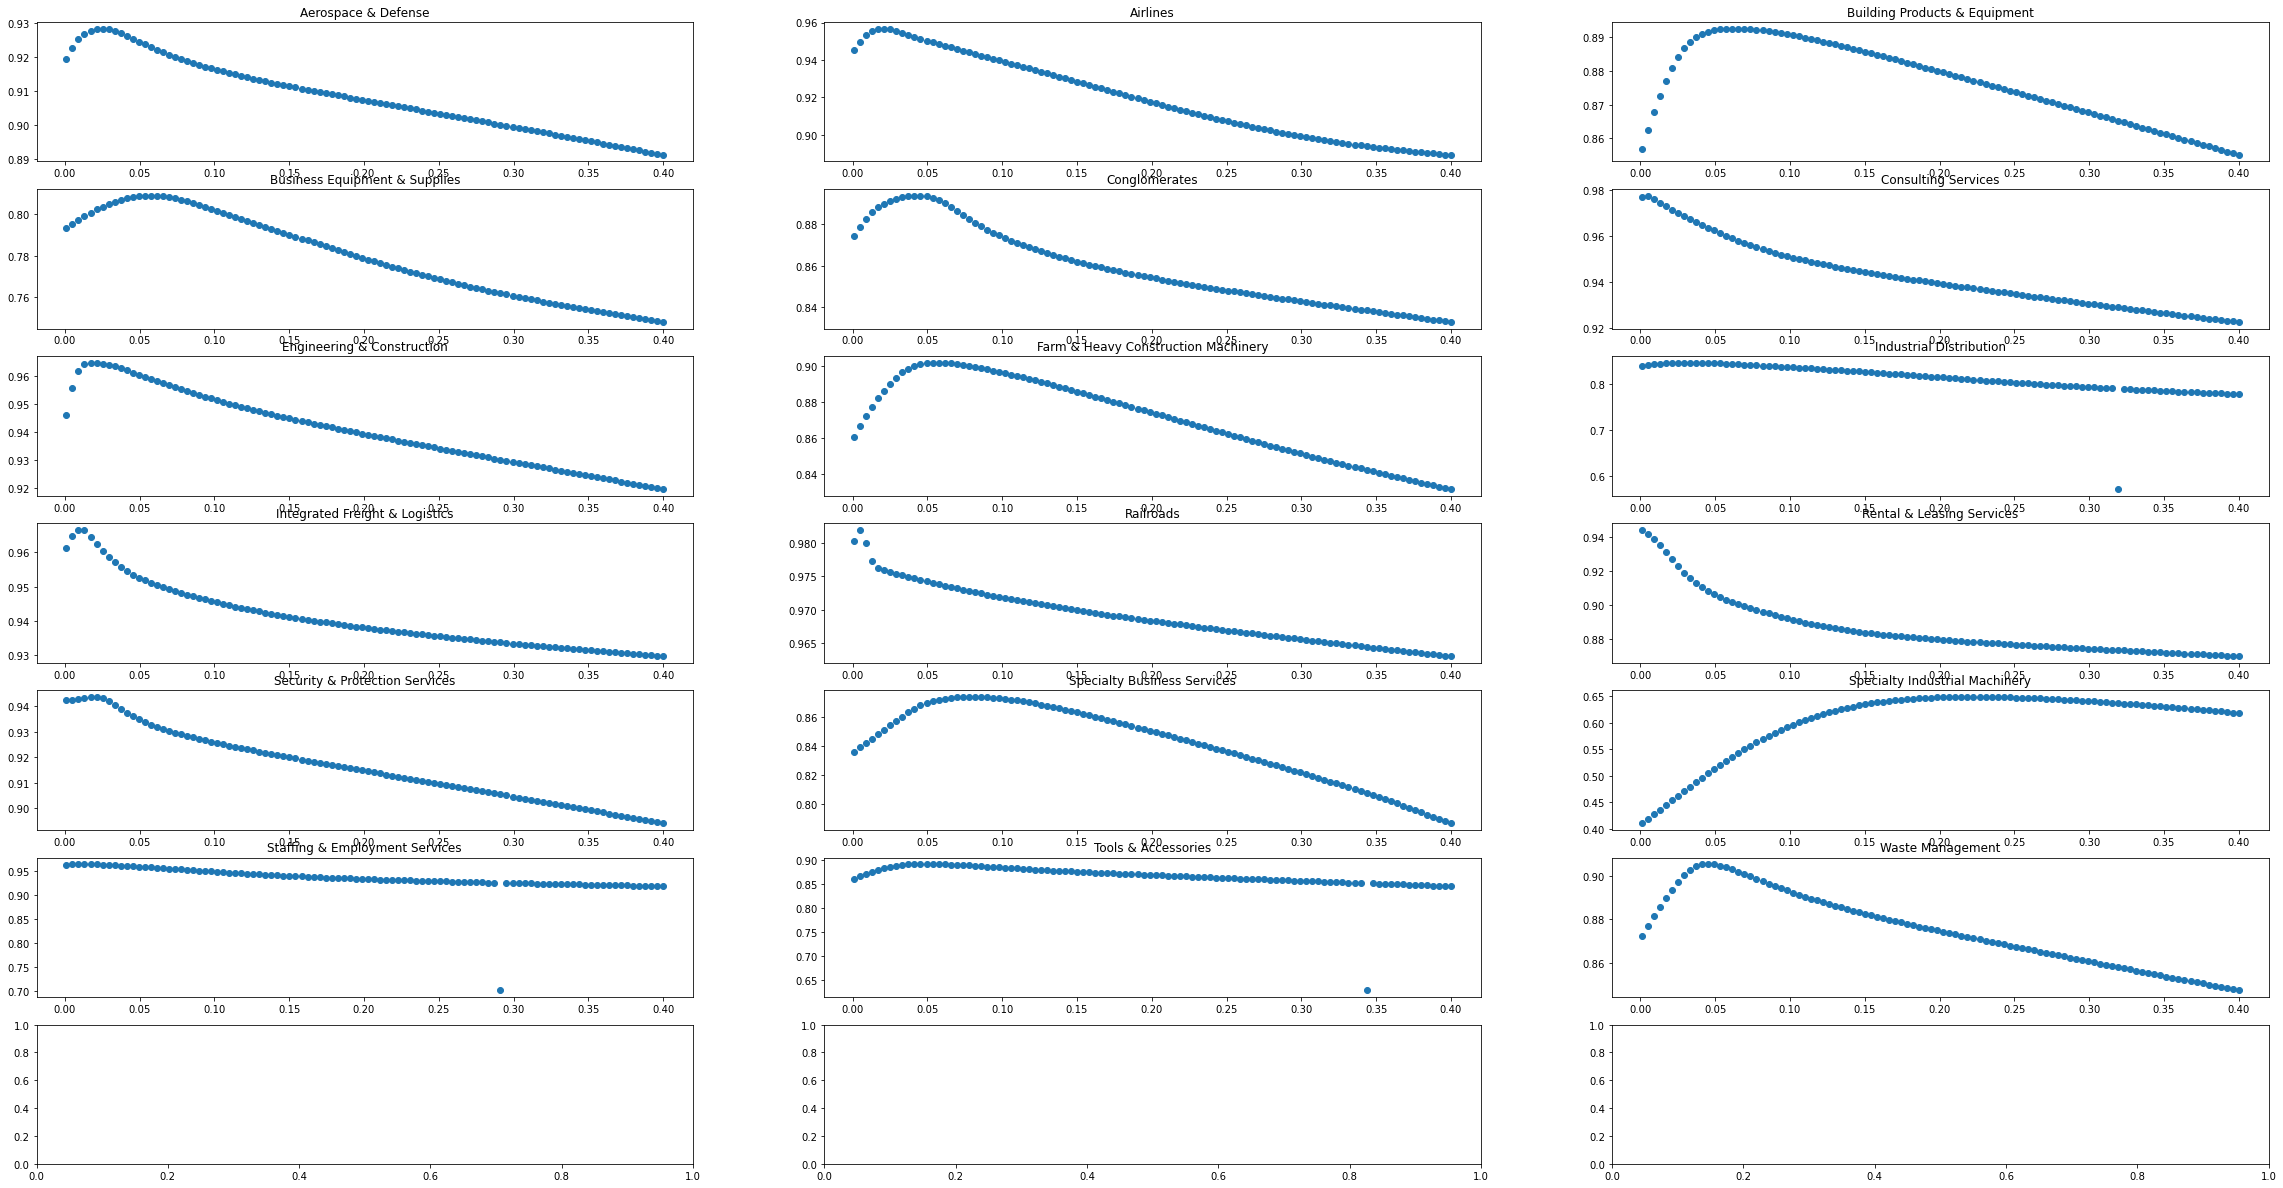

In [197]:
plot_gp_search(industrial_search_out,horizontal_size=3)

In [198]:
Industrial_esg.to_pickle('../Yahoo/Industrial_esg.pkl')

# Energy

In [202]:
Energy_dict = pd.read_pickle('../Yahoo/Energy_Industry.pkl')
Energy_esg = Energy_dict['data']
Energy_esg_index = Energy_dict['index']
Energy_gp, Energy_gp_std, Energy_gp_out, Energy_search_out = opt_all_col(Energy_esg, Energy_esg_index)

Oil & Gas E&P
{'alpha': 0.005030303030303031}
Oil & Gas Equipment & Services
{'alpha': 0.10981818181818183}
Oil & Gas Integrated
{'alpha': 0.20654545454545456}
Oil & Gas Midstream
{'alpha': 0.04130303030303031}
Oil & Gas Refining & Marketing
{'alpha': 0.16221212121212122}


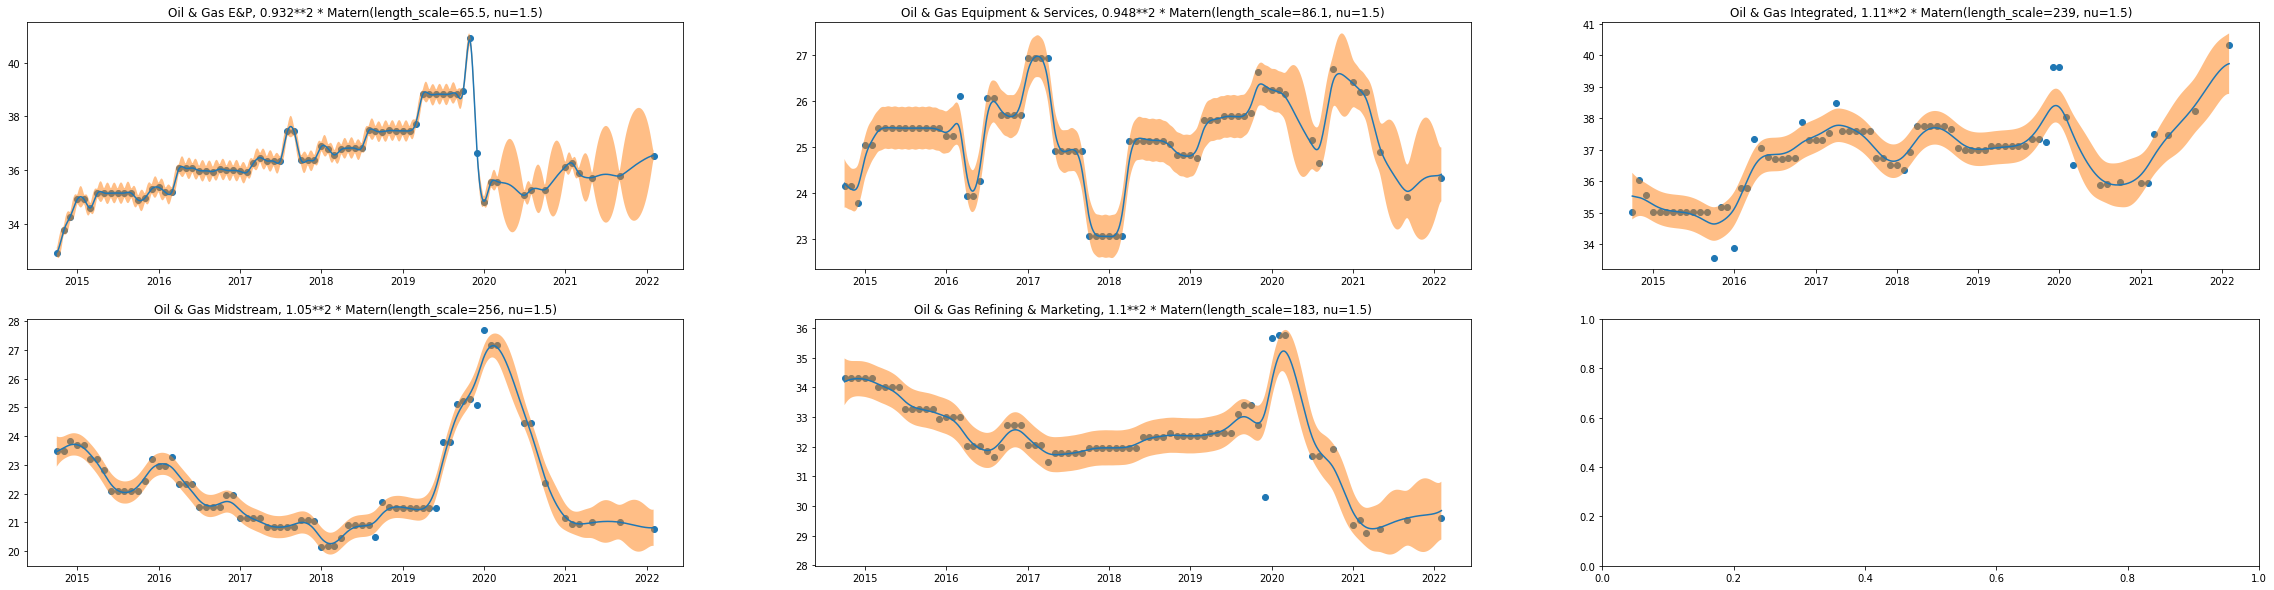

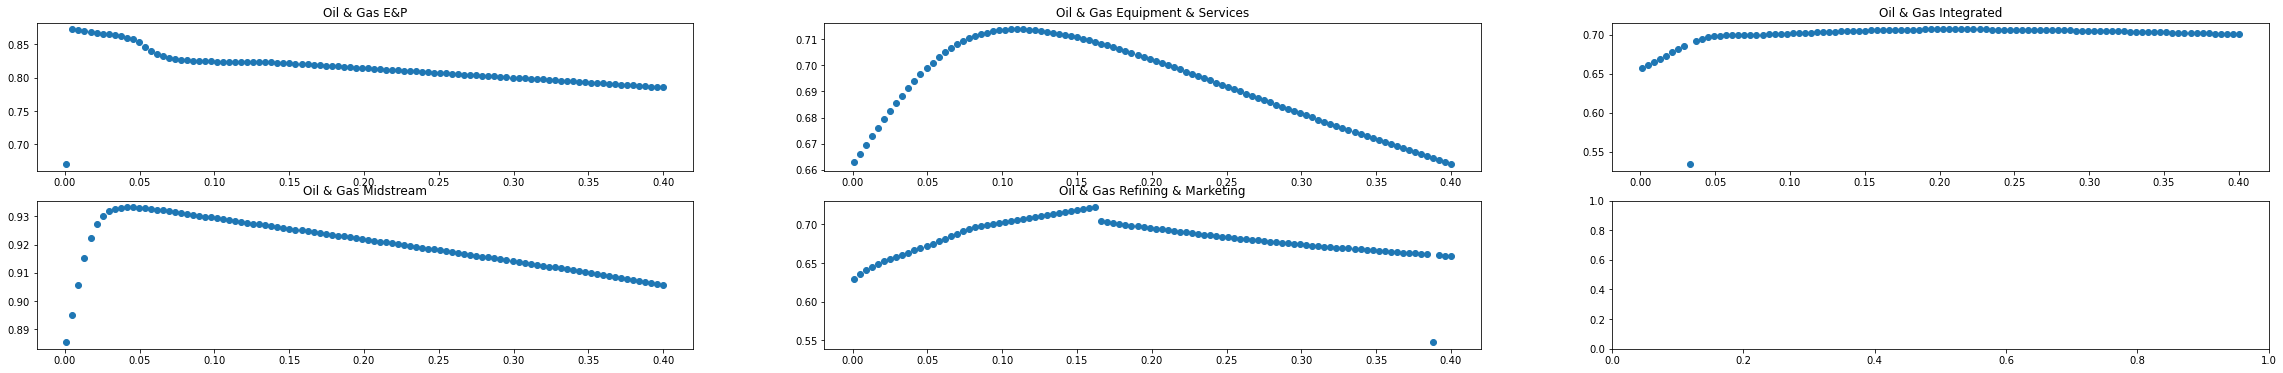

In [203]:
plot_gp_fit_sector(Energy_esg,Energy_esg_index, Energy_gp, Energy_gp_std, Energy_gp_out)
plot_gp_search(Energy_search_out,horizontal_size=3)

In [209]:
Energy_gp.to_pickle('../Yahoo/Energy_gp.pkl')

# Utilities

In [205]:
Utilities_dict = pd.read_pickle('../Yahoo/Utilities_Industry.pkl')
Utilities_esg = Utilities_dict['data']
Utilities_esg_index = Utilities_dict['index']
Utilities_gp, Utilities_gp_std, Utilities_gp_out, Utilities_search_out = opt_all_col(Utilities_esg, Utilities_esg_index)

Utilities—Diversified
{'alpha': 0.009020100502512562}
Utilities—Independent Power Producers
{'alpha': 0.049120603015075384}
Utilities—Regulated Electric
{'alpha': 0.045110552763819096}
Utilities—Regulated Gas
{'alpha': 0.07117587939698493}
Utilities—Regulated Water
{'alpha': 0.055135678391959805}


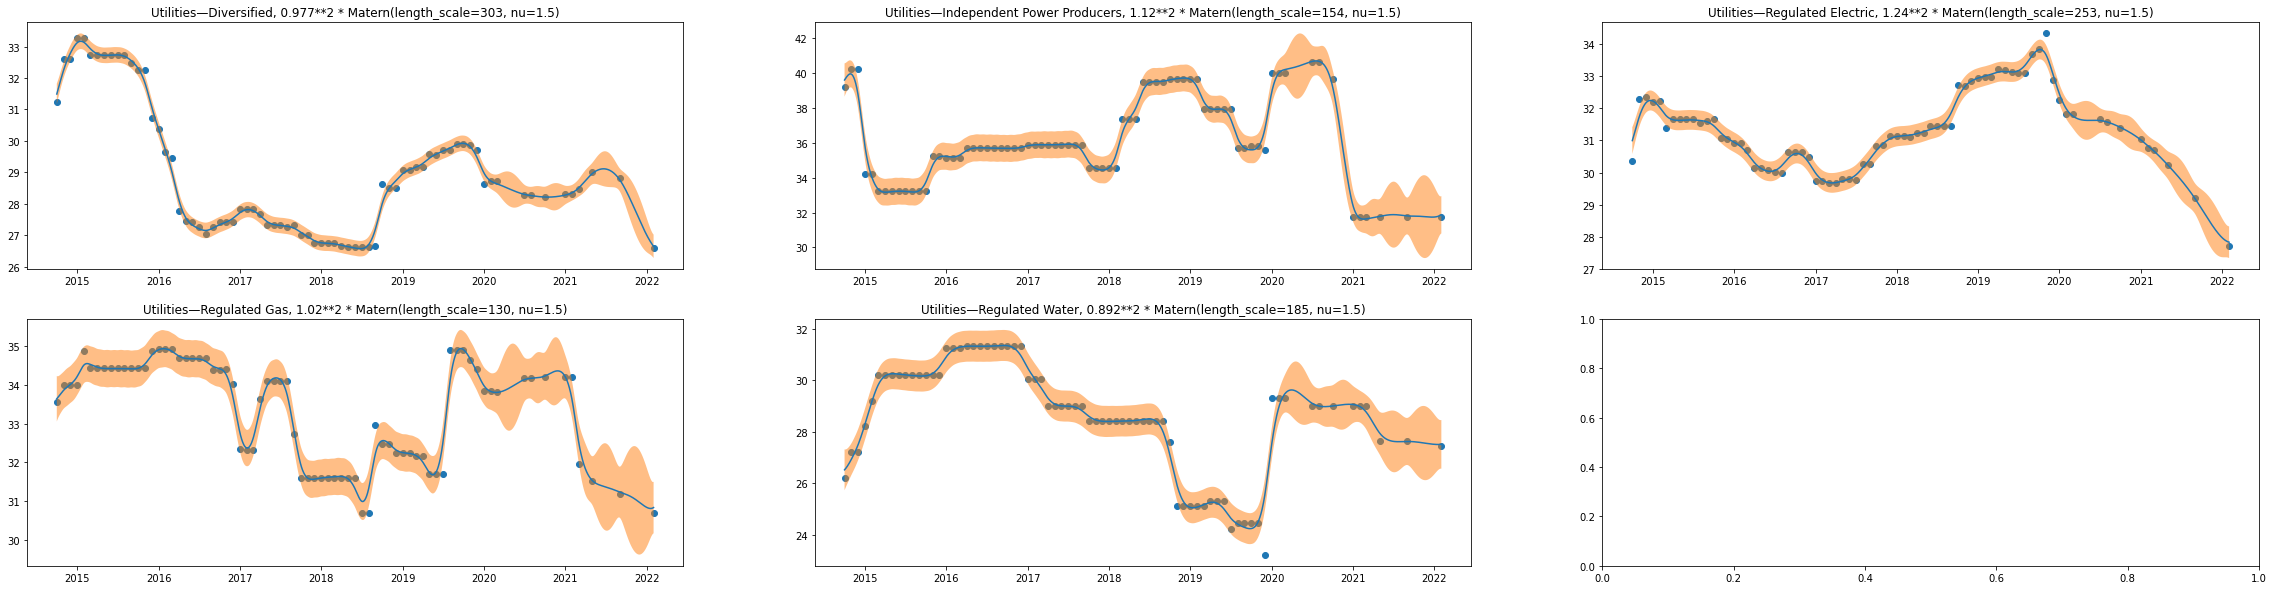

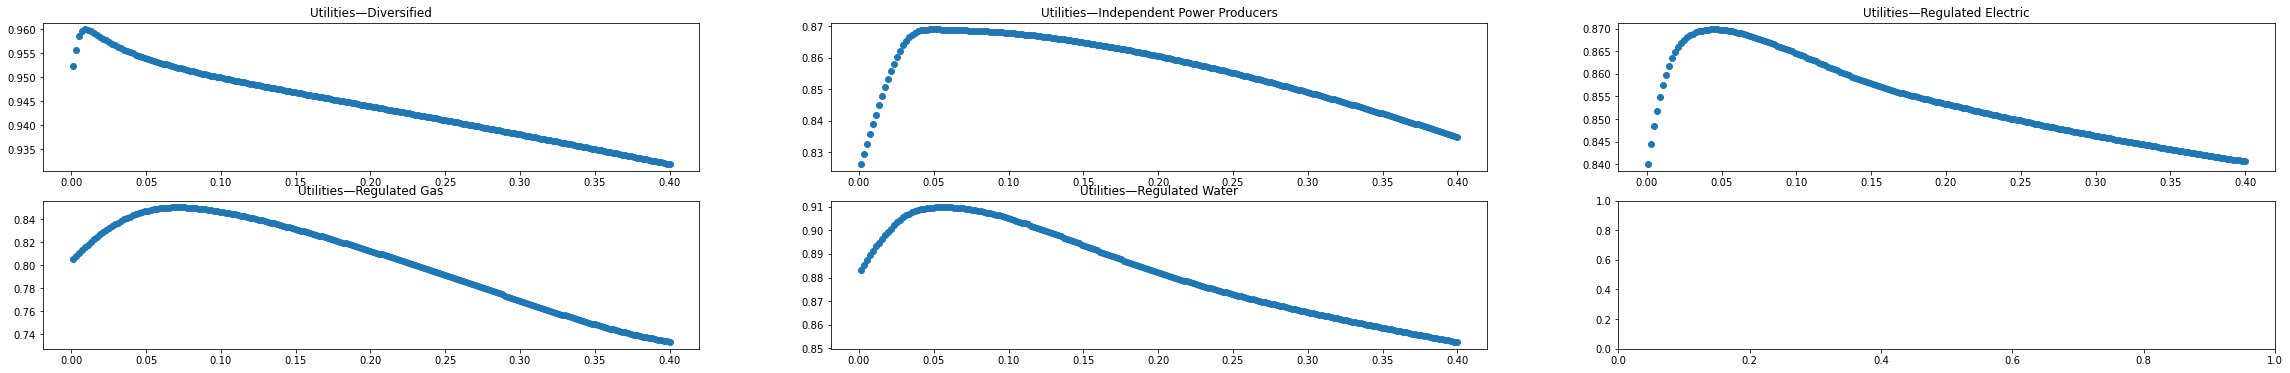

In [206]:
plot_gp_fit_sector(Utilities_esg,Utilities_esg_index, Utilities_gp, Utilities_gp_std, Utilities_gp_out)
plot_gp_search(Utilities_search_out,horizontal_size=3)

In [210]:
Utilities_gp.to_pickle('../Yahoo/Utilities_gp.pkl')

# Basic Materials

In [208]:
BasicMaterials_dict = pd.read_pickle('../Yahoo/BasicMaterials_Industry.pkl')
BasicMaterials_esg = BasicMaterials_dict['data']
BasicMaterials_esg_index = BasicMaterials_dict['index']
BasicMaterials_gp, BasicMaterials_gp_std, BasicMaterials_gp_out, BasicMaterials_search_out = opt_all_col(BasicMaterials_esg, BasicMaterials_esg_index)

Agricultural Inputs
{'alpha': 0.041201680672268905}
Building Materials
{'alpha': 0.09145378151260504}
Chemicals
{'alpha': 0.001}
Copper
{'alpha': 0.11909243697478991}
Gold
{'alpha': 0.013563025210084033}
Specialty Chemicals
{'alpha': 0.12411764705882351}
Steel
{'alpha': 0.06884033613445377}


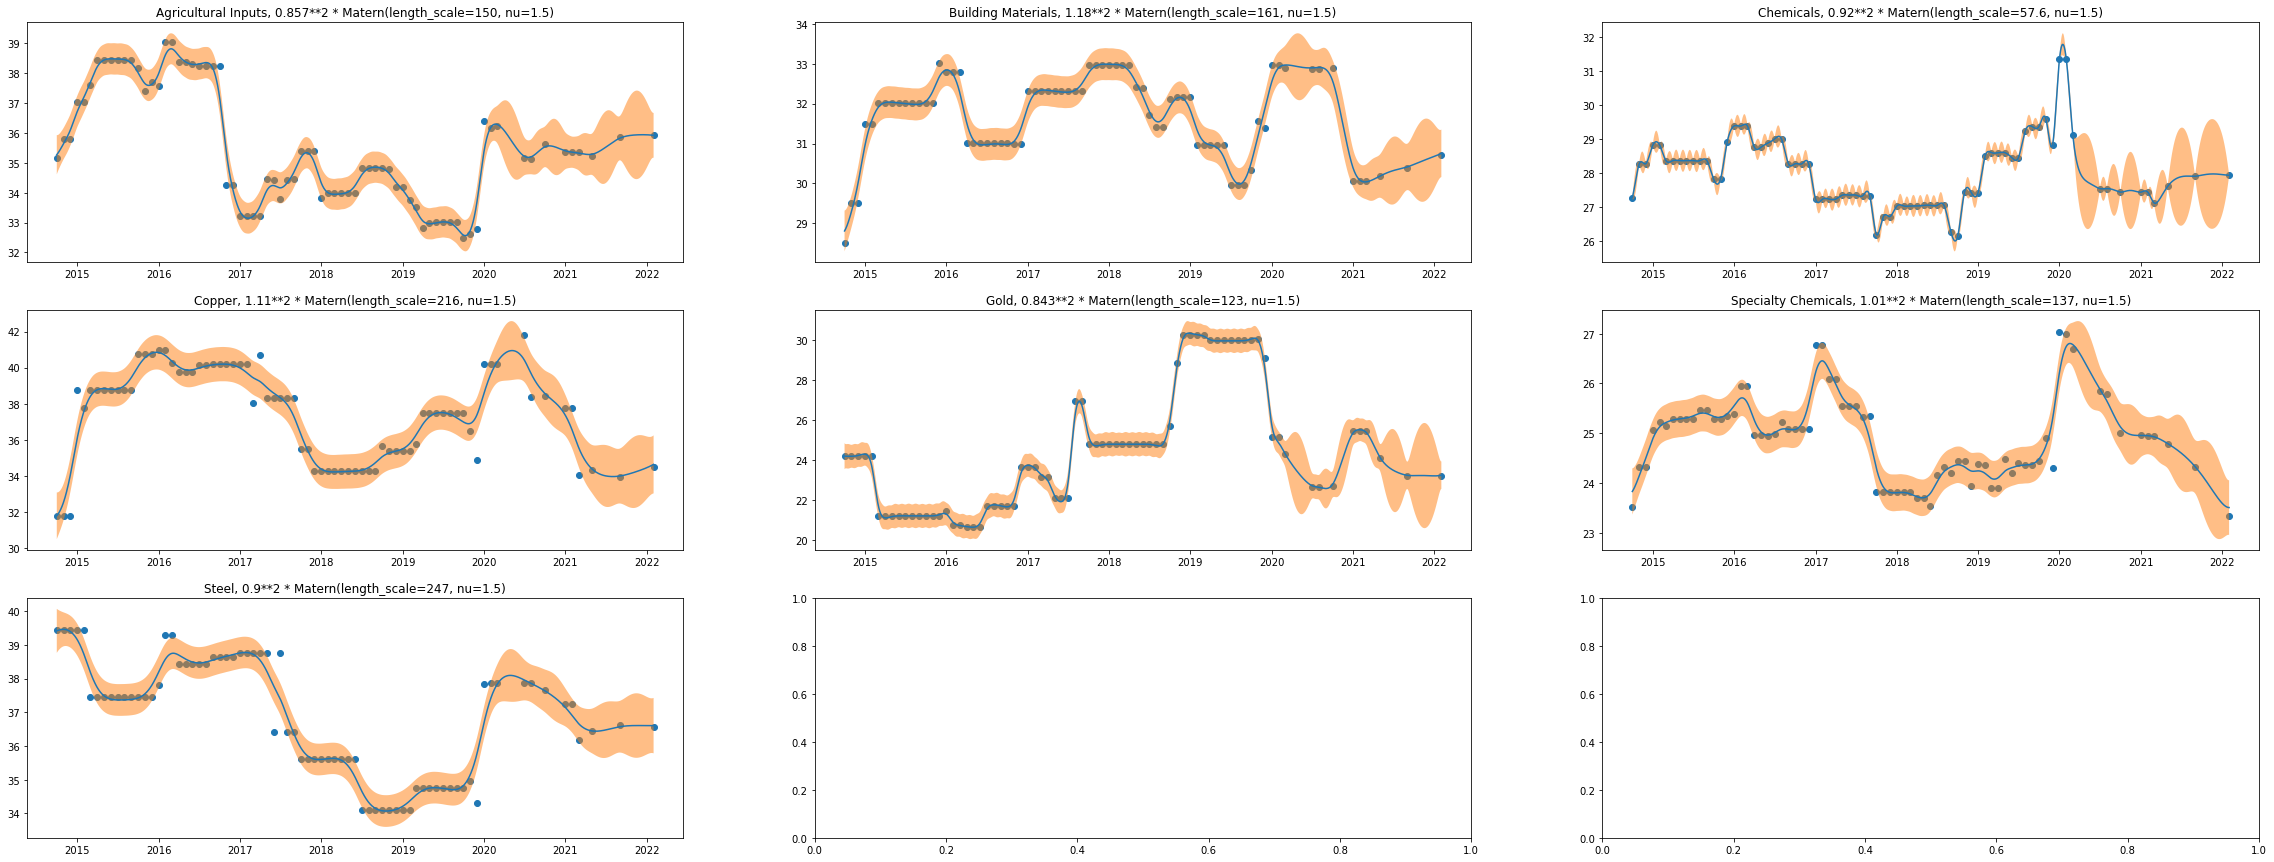

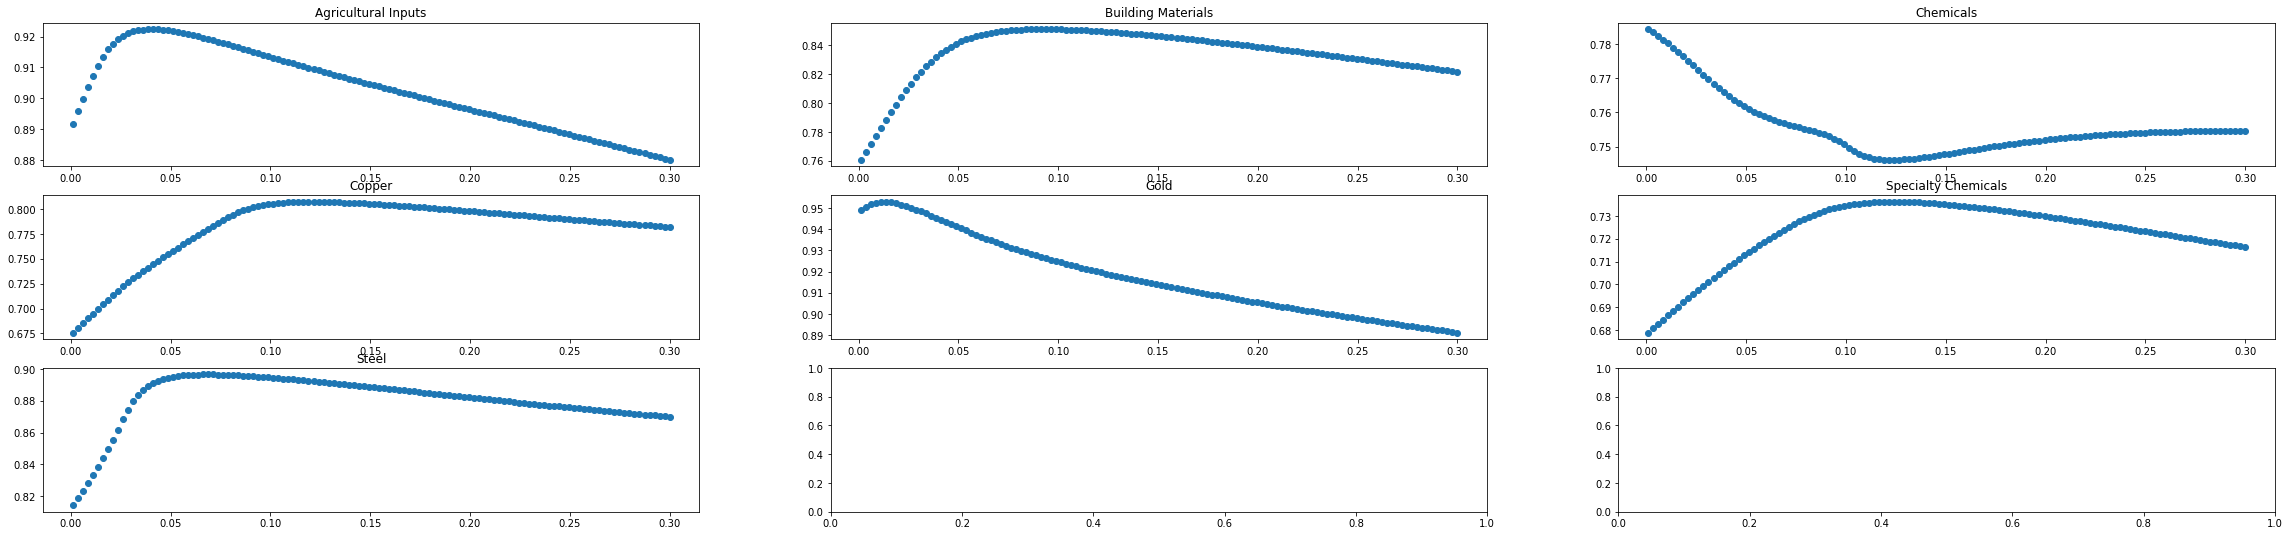

In [211]:
plot_gp_fit_sector(BasicMaterials_esg,BasicMaterials_esg_index, BasicMaterials_gp, BasicMaterials_gp_std, BasicMaterials_gp_out)
plot_gp_search(BasicMaterials_search_out,horizontal_size=3)

In [212]:
BasicMaterials_gp.to_pickle('../Yahoo/BasicMaterials_gp.pkl')

# Financial Services

In [213]:
FinancialServices_dict = pd.read_pickle('../Yahoo/FinancialServices_Industry.pkl')
FinancialServices_esg = FinancialServices_dict['data']
FinancialServices_esg_index = FinancialServices_dict['index']
FinancialServices_gp, FinancialServices_gp_std, FinancialServices_gp_out, FinancialServices_search_out = opt_all_col(FinancialServices_esg, FinancialServices_esg_index)

Asset Management
{'alpha': 0.04622689075630252}
Banks—Diversified
{'alpha': 0.04622689075630252}
Banks—Regional
{'alpha': 0.006025210084033613}
Capital Markets
{'alpha': 0.03115126050420168}
Credit Services
{'alpha': 0.03366386554621849}
Financial Data & Stock Exchanges
{'alpha': 0.028638655462184873}
Insurance Brokers
{'alpha': 0.04622689075630252}
Insurance—Diversified
{'alpha': 0.07135294117647058}
Insurance—Life
{'alpha': 0.026126050420168065}
Insurance—Property & Casualty
{'alpha': 0.011050420168067225}
Insurance—Reinsurance
{'alpha': 0.018588235294117645}
Insurance—Specialty
{'alpha': 0.06130252100840336}


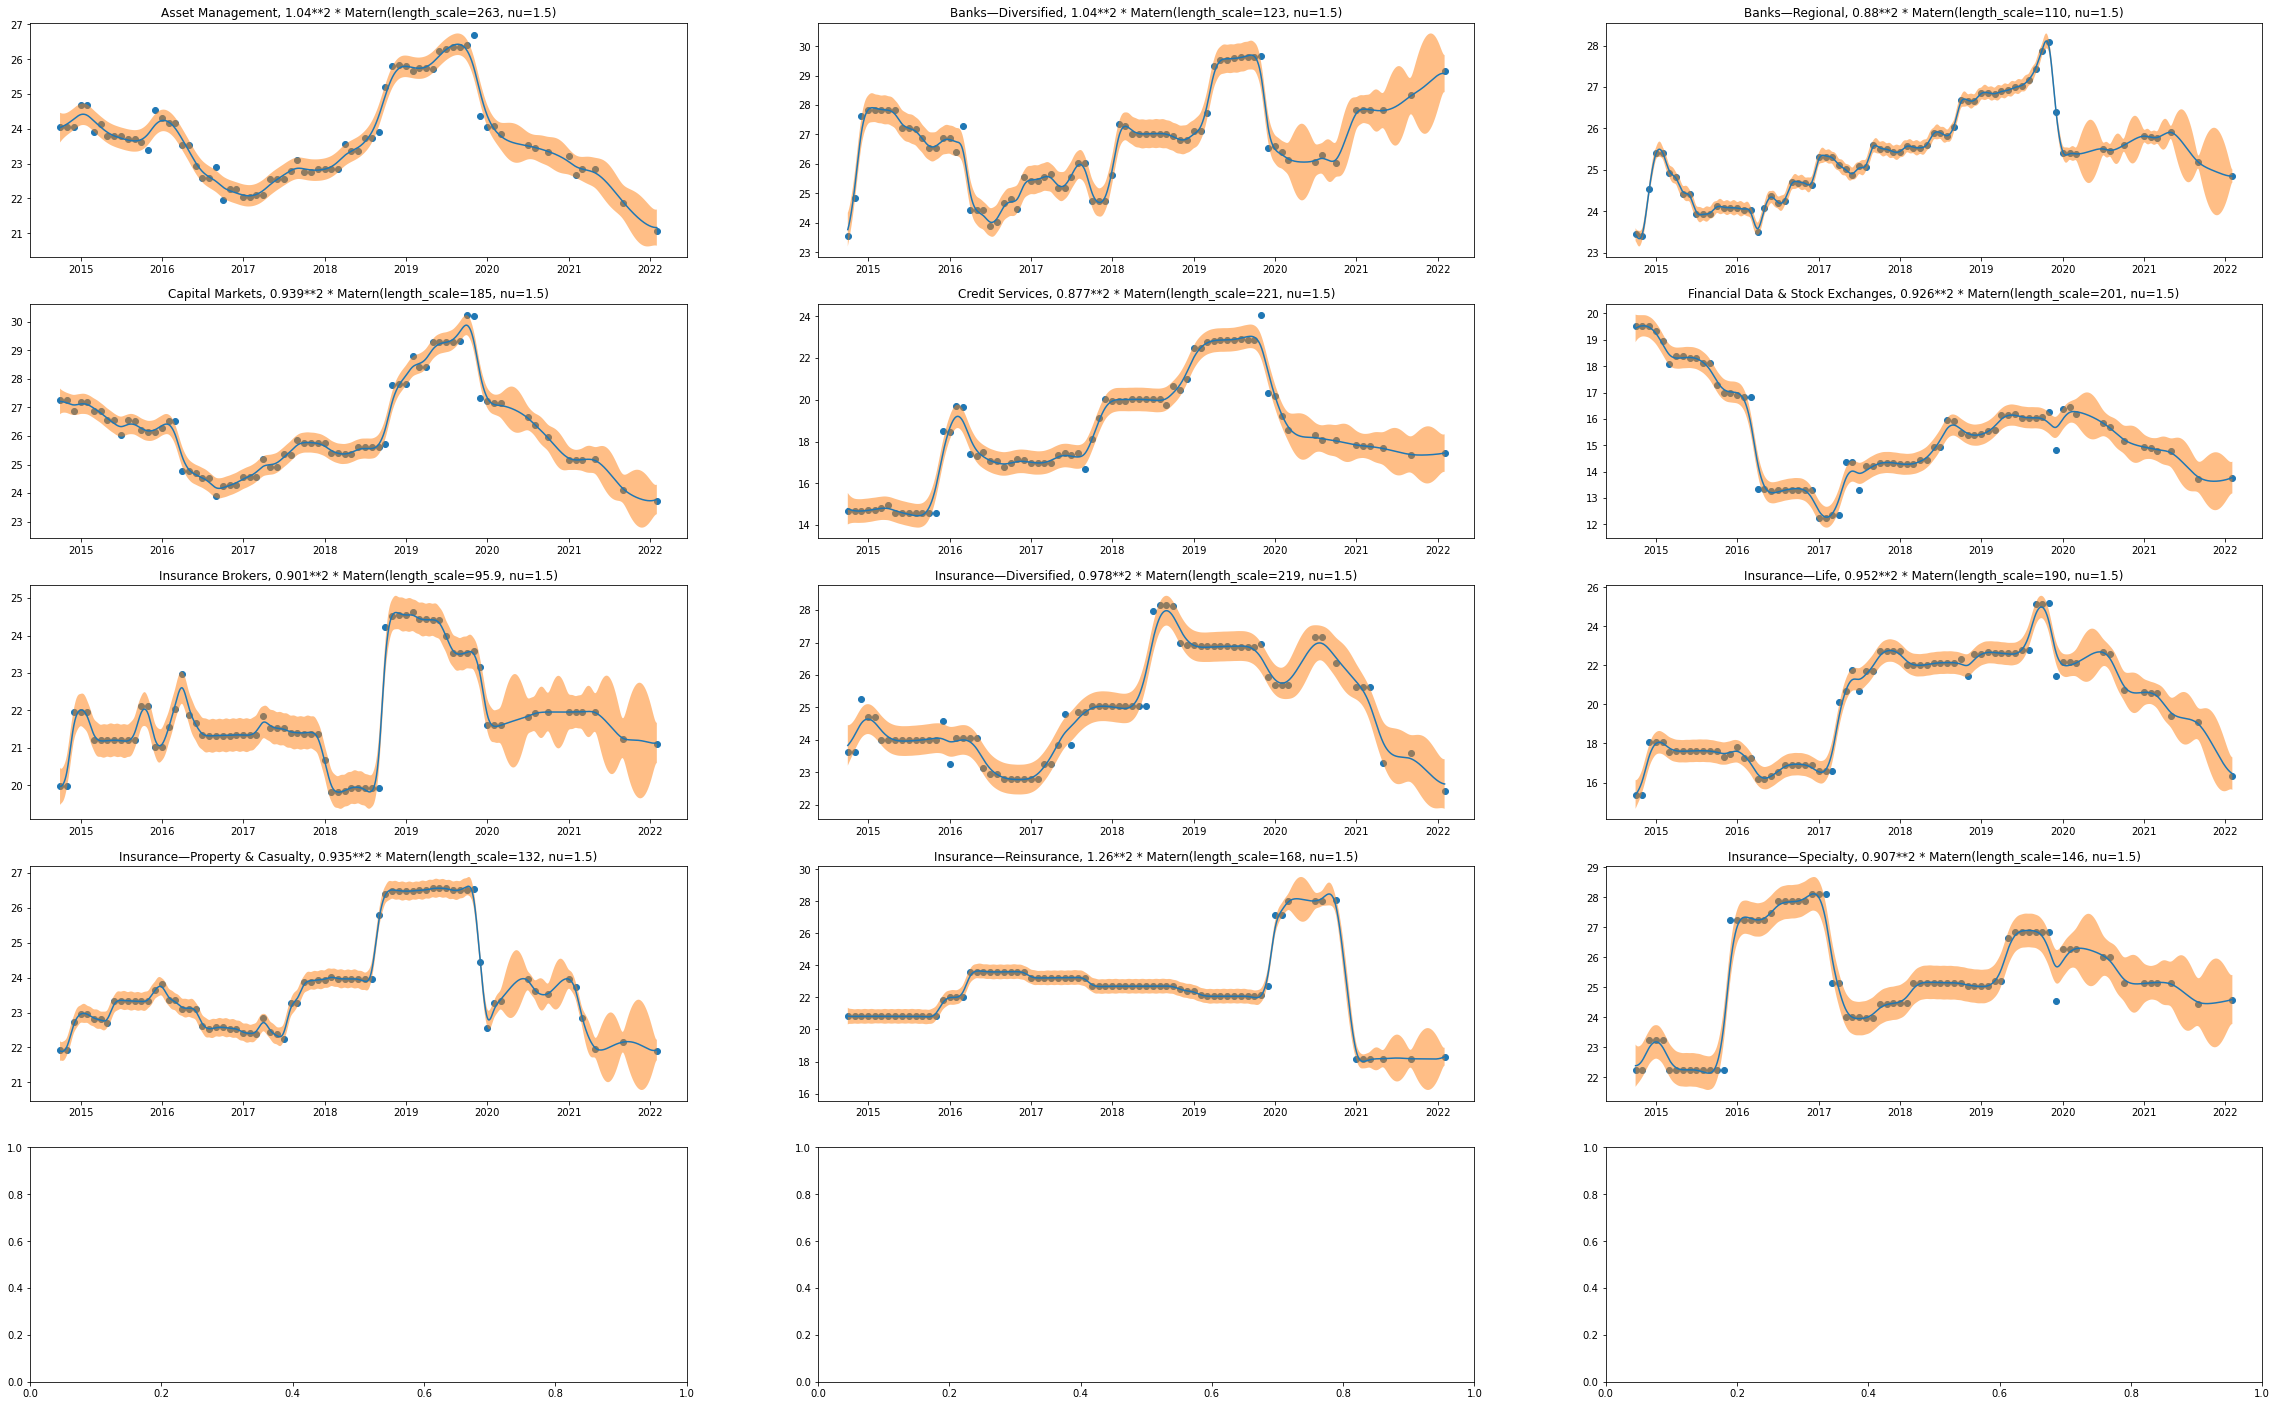

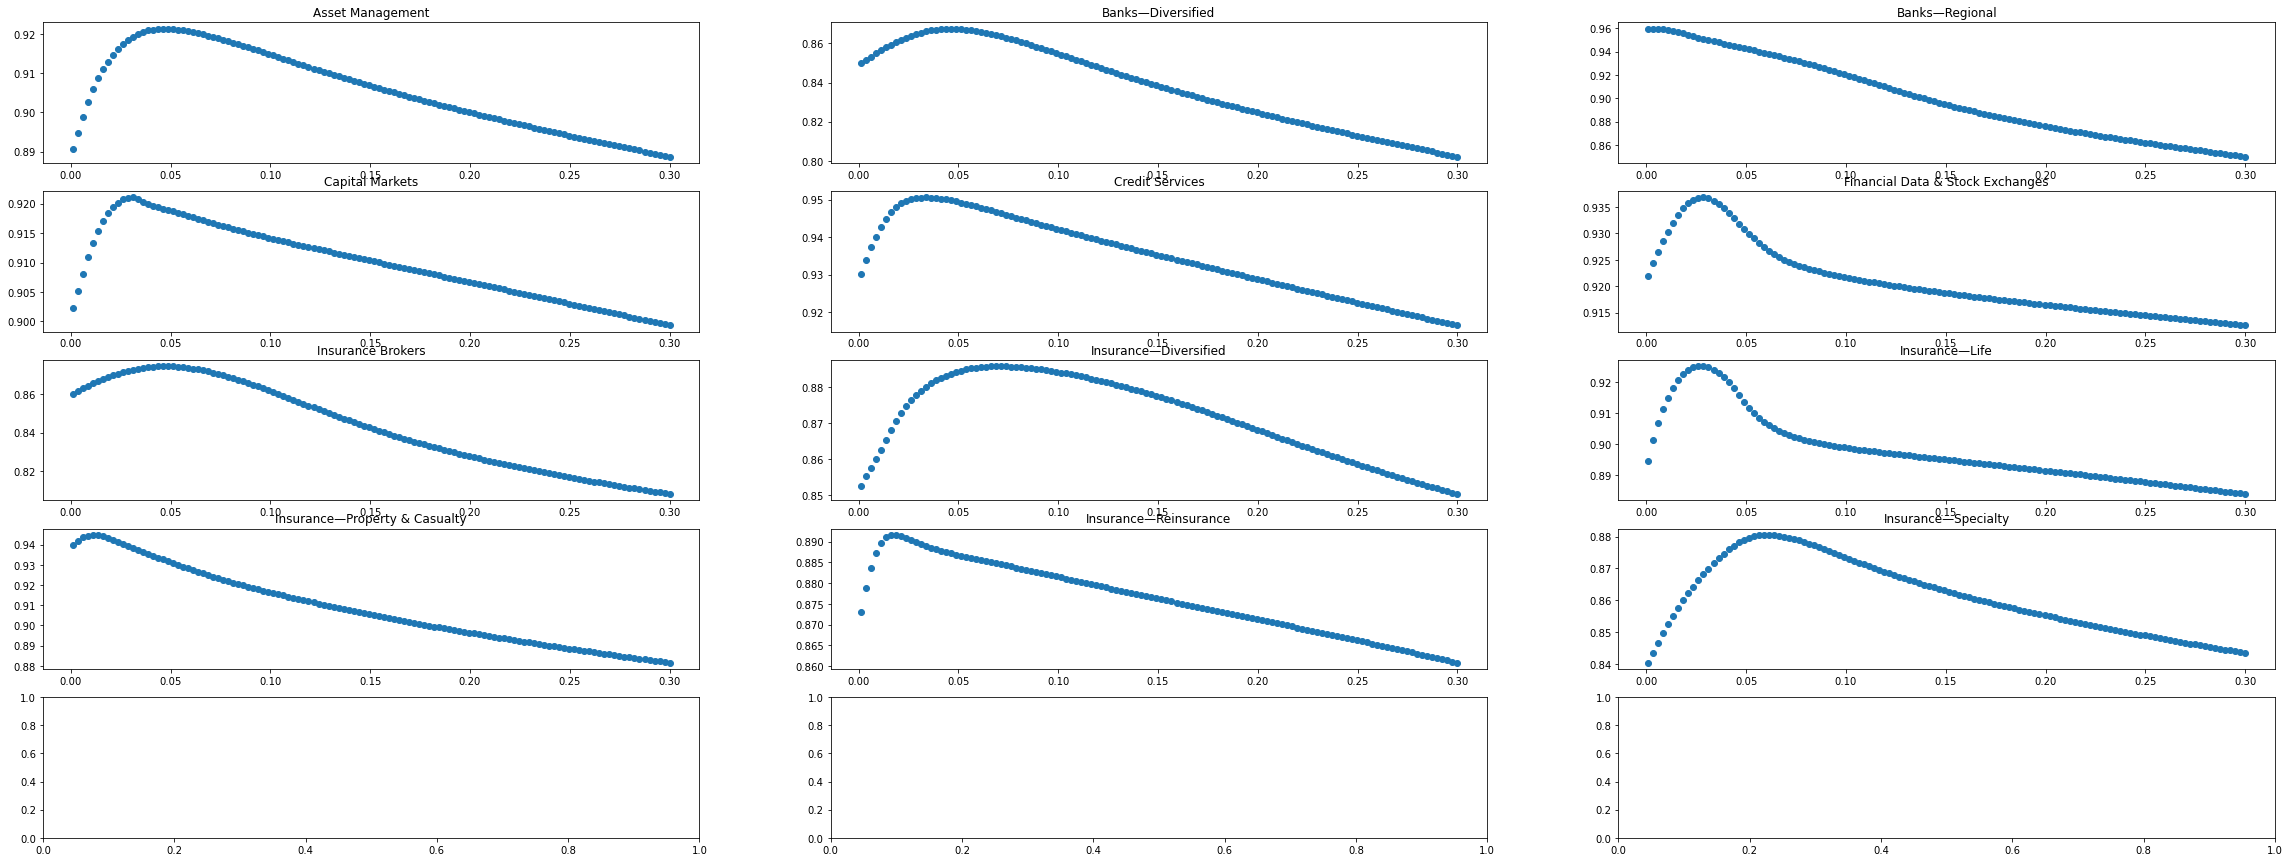

In [214]:
plot_gp_fit_sector(FinancialServices_esg,FinancialServices_esg_index, FinancialServices_gp, FinancialServices_gp_std, FinancialServices_gp_out)
plot_gp_search(FinancialServices_search_out,horizontal_size=3)

In [224]:
np.cov(FinancialServices_gp['Insurance—Reinsurance'][2400:])

array(0.00078912)

In [215]:
FinancialServices_gp.to_pickle('../Yahoo/FinancialServices_gp.pkl')

# Consumer Defensive

In [225]:
ConsumerDefensive_dict = pd.read_pickle('../Yahoo/ConsumerDefensive_Industry.pkl')
ConsumerDefensive_esg = ConsumerDefensive_dict['data']
ConsumerDefensive_esg_index = ConsumerDefensive_dict['index']
ConsumerDefensive_gp, ConsumerDefensive_gp_std, ConsumerDefensive_gp_out, ConsumerDefensive_search_out = opt_all_col(ConsumerDefensive_esg, ConsumerDefensive_esg_index)

Beverages—Brewers
{'alpha': 0.06130252100840336}
Beverages—Non-Alcoholic
{'alpha': 0.011050420168067225}
Beverages—Wineries & Distilleries
{'alpha': 0.04873949579831932}
Confectioners
{'alpha': 0.001}
Discount Stores
{'alpha': 0.20703361344537813}
Farm Products
{'alpha': 0.08894117647058823}
Food Distribution
{'alpha': 0.028638655462184873}
Grocery Stores
{'alpha': 0.03115126050420168}
Household & Personal Products
{'alpha': 0.0035126050420168065}
Packaged Foods
{'alpha': 0.2623109243697479}
Tobacco
{'alpha': 0.15175630252100838}


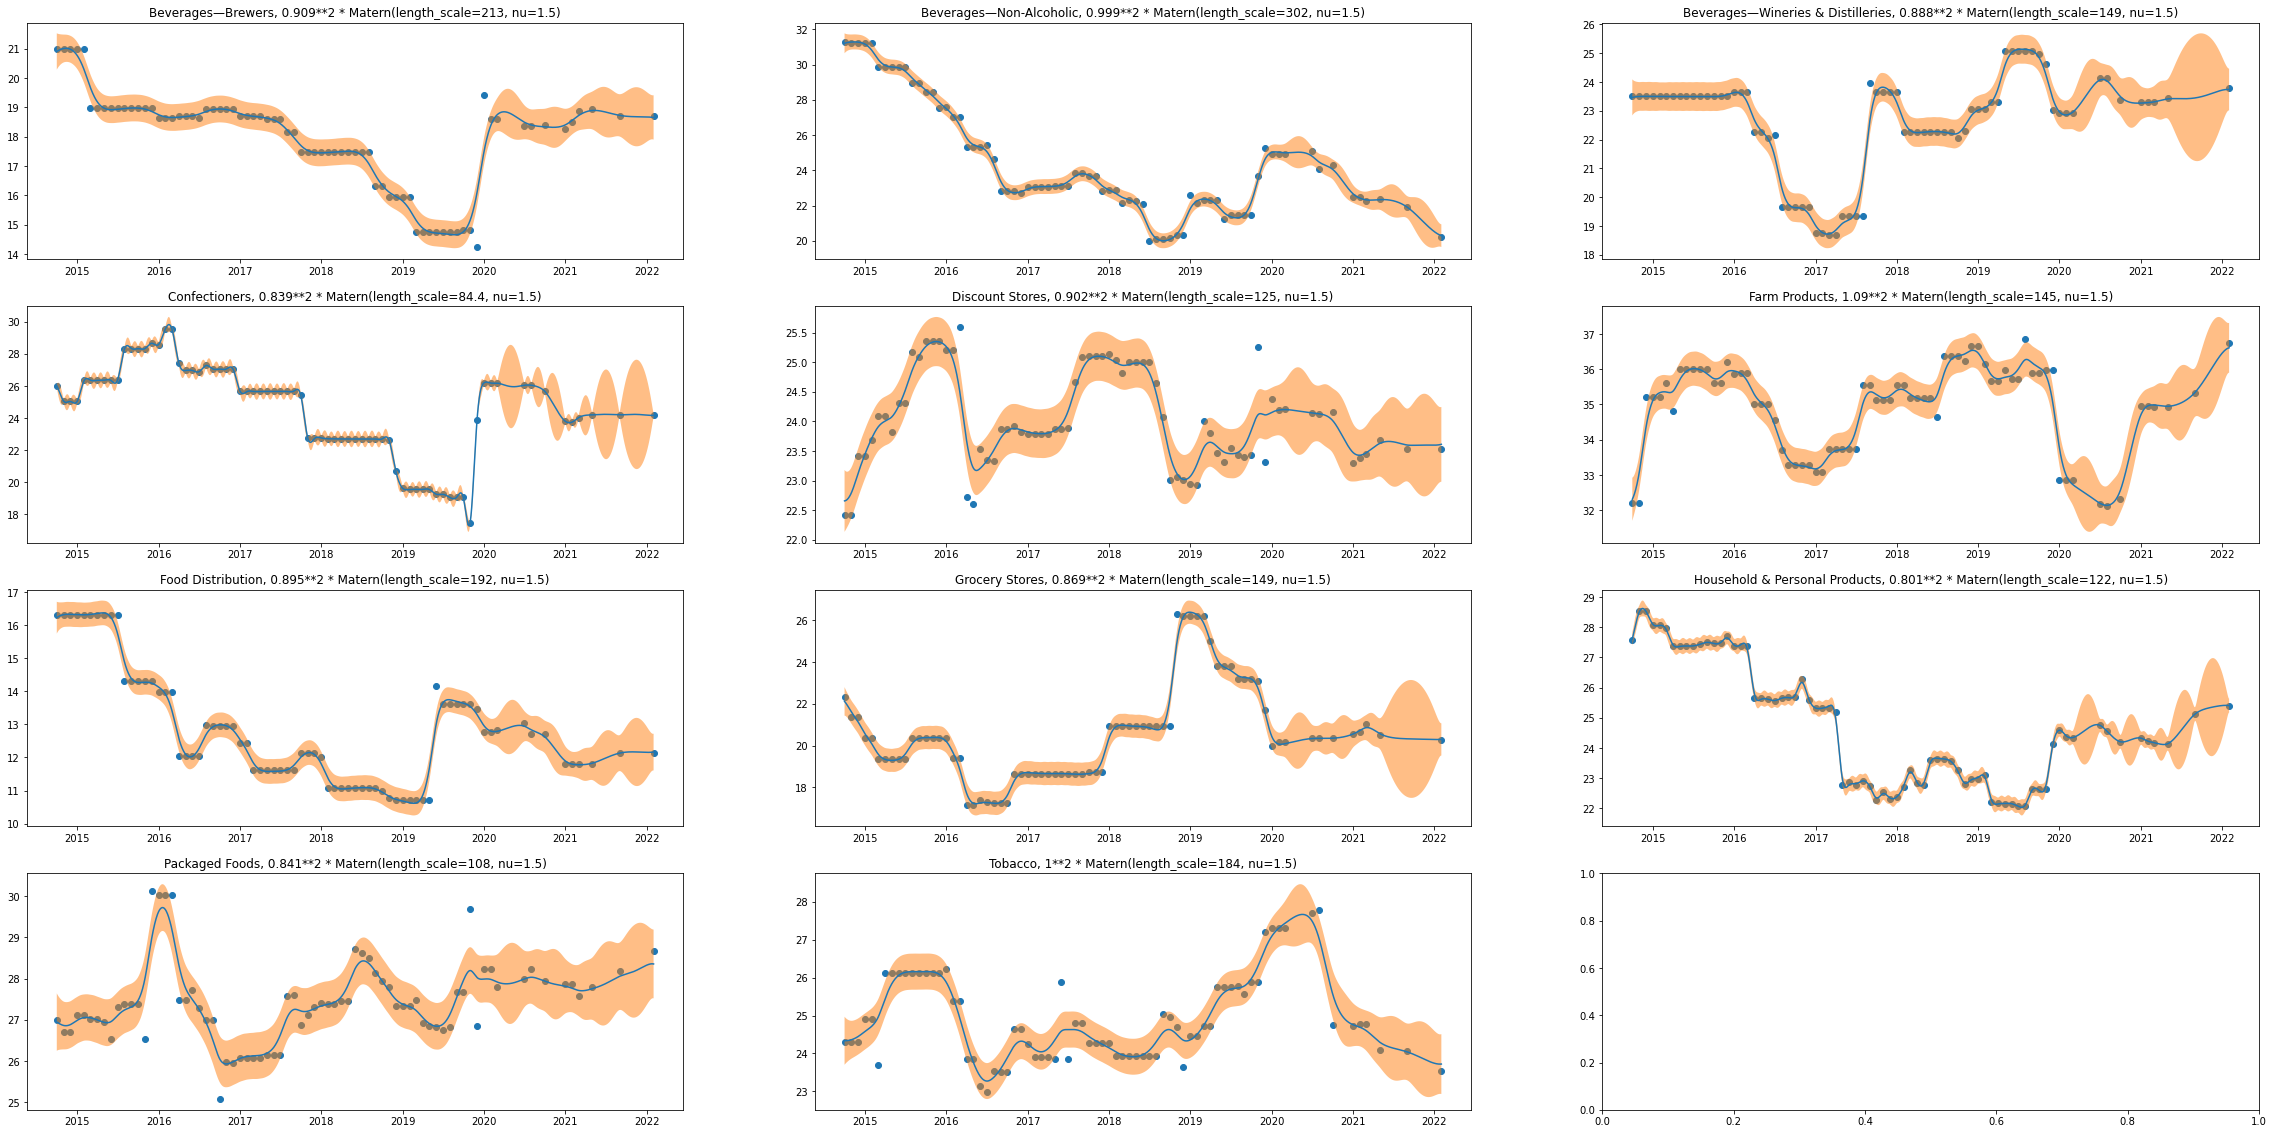

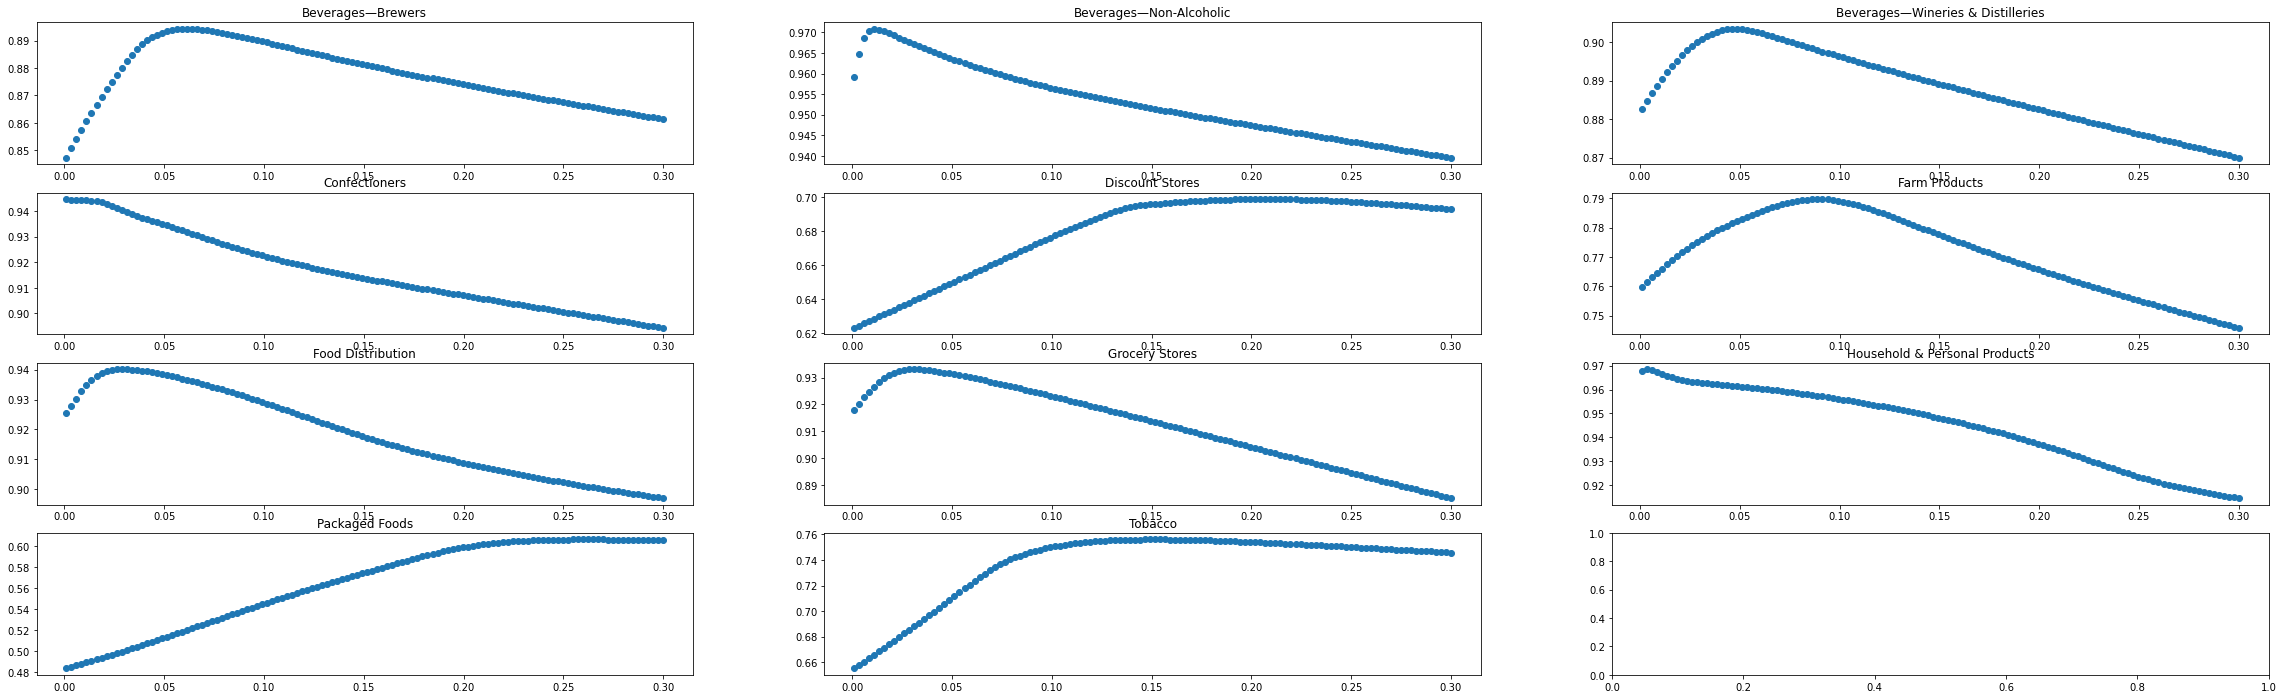

In [226]:
plot_gp_fit_sector(ConsumerDefensive_esg,ConsumerDefensive_esg_index, ConsumerDefensive_gp, ConsumerDefensive_gp_std, ConsumerDefensive_gp_out)
plot_gp_search(ConsumerDefensive_search_out,horizontal_size=3)
ConsumerDefensive_gp.to_pickle('../Yahoo/ConsumerDefensive_gp.pkl')

# Consumer Cyclical

In [227]:
ConsumerCyclical_dict = pd.read_pickle('../Yahoo/ConsumerCyclical_Industry.pkl')
ConsumerCyclical_esg = ConsumerCyclical_dict['data']
ConsumerCyclical_esg_index = ConsumerCyclical_dict['index']
ConsumerCyclical_gp, ConsumerCyclical_gp_std, ConsumerCyclical_gp_out, ConsumerCyclical_search_out = opt_all_col(ConsumerCyclical_esg, ConsumerCyclical_esg_index)

Apparel Manufacturing
{'alpha': 0.06130252100840336}
Apparel Retail
{'alpha': 0.13668067226890754}
Auto & Truck Dealerships
{'alpha': 0.018588235294117645}
Auto Manufacturers
{'alpha': 0.06884033613445377}
Auto Parts
{'alpha': 0.041201680672268905}
Footwear & Accessories
{'alpha': 0.00853781512605042}
Furnishings, Fixtures & Appliances
{'alpha': 0.06632773109243698}
Home Improvement Retail
{'alpha': 0.03115126050420168}
Internet Retail
{'alpha': 0.03115126050420168}
Leisure
{'alpha': 0.08642857142857142}
Lodging
{'alpha': 0.13165546218487395}
Luxury Goods
{'alpha': 0.056277310924369744}
Packaging & Containers
{'alpha': 0.06632773109243698}
Personal Services
{'alpha': 0.07135294117647058}
Residential Construction
{'alpha': 0.05125210084033613}
Resorts & Casinos
{'alpha': 0.07637815126050419}
Restaurants
{'alpha': 0.021100840336134453}
Specialty Retail
{'alpha': 0.08391596638655462}
Travel Services
{'alpha': 0.05878991596638655}


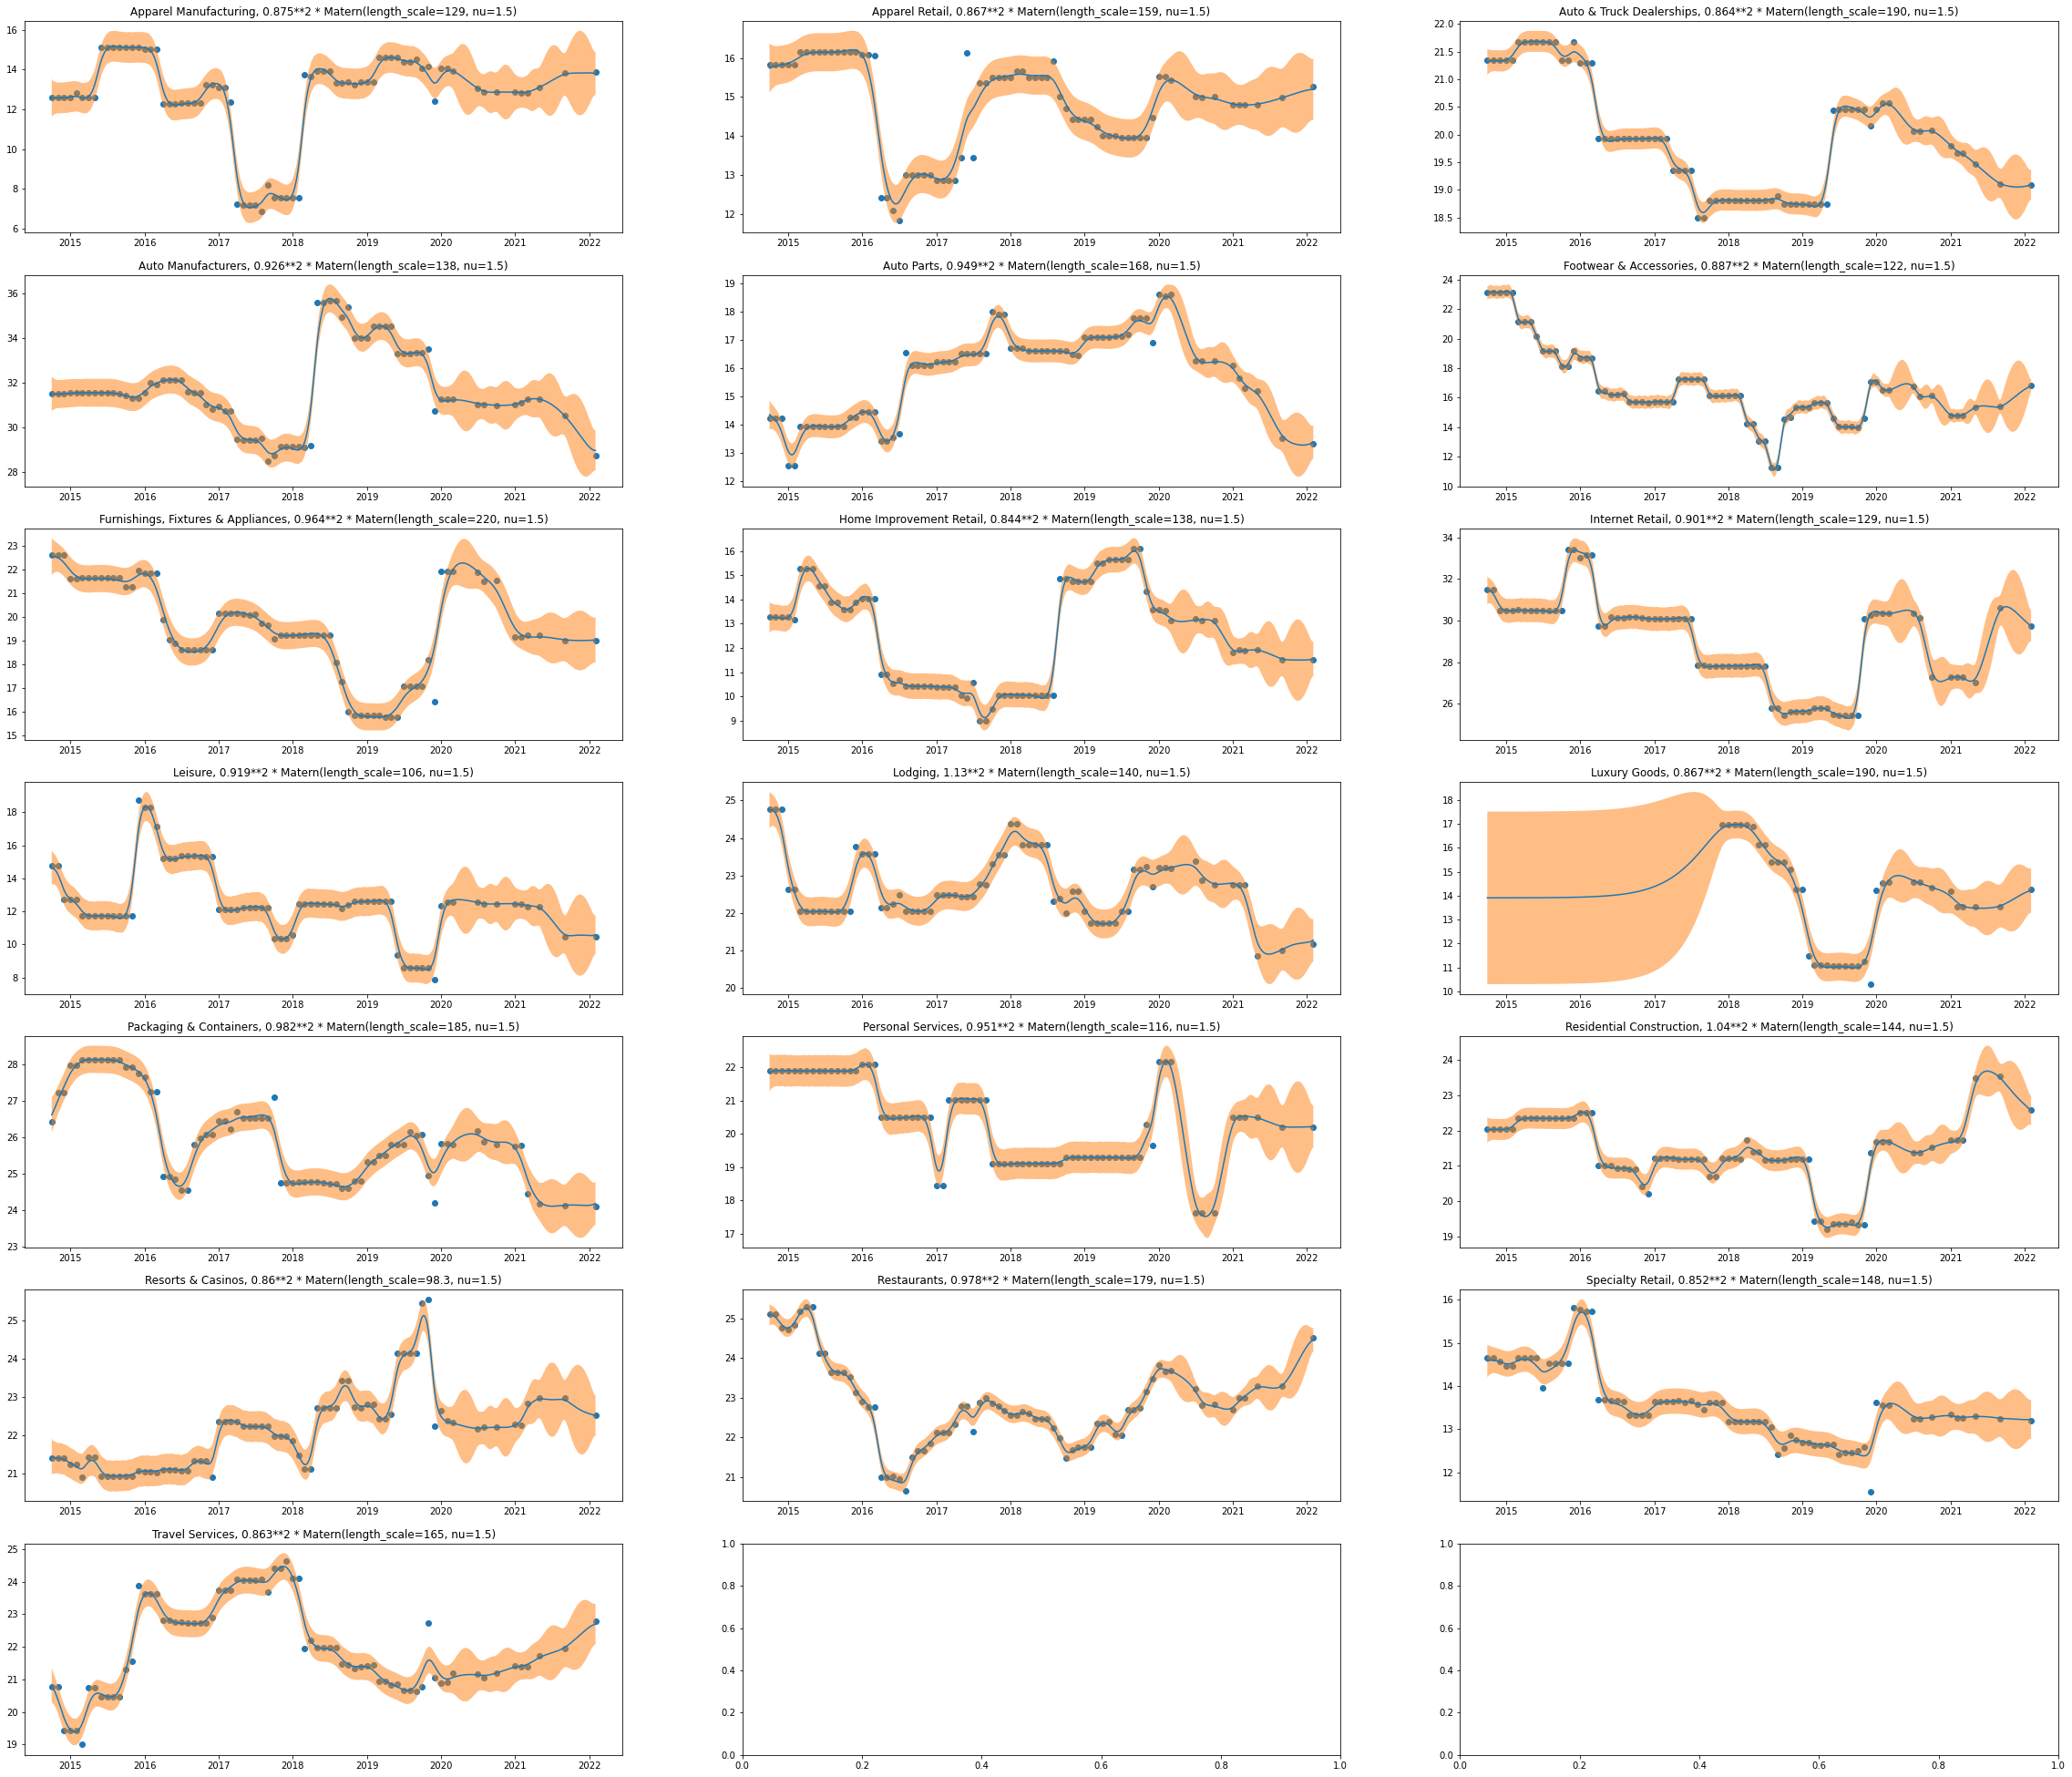

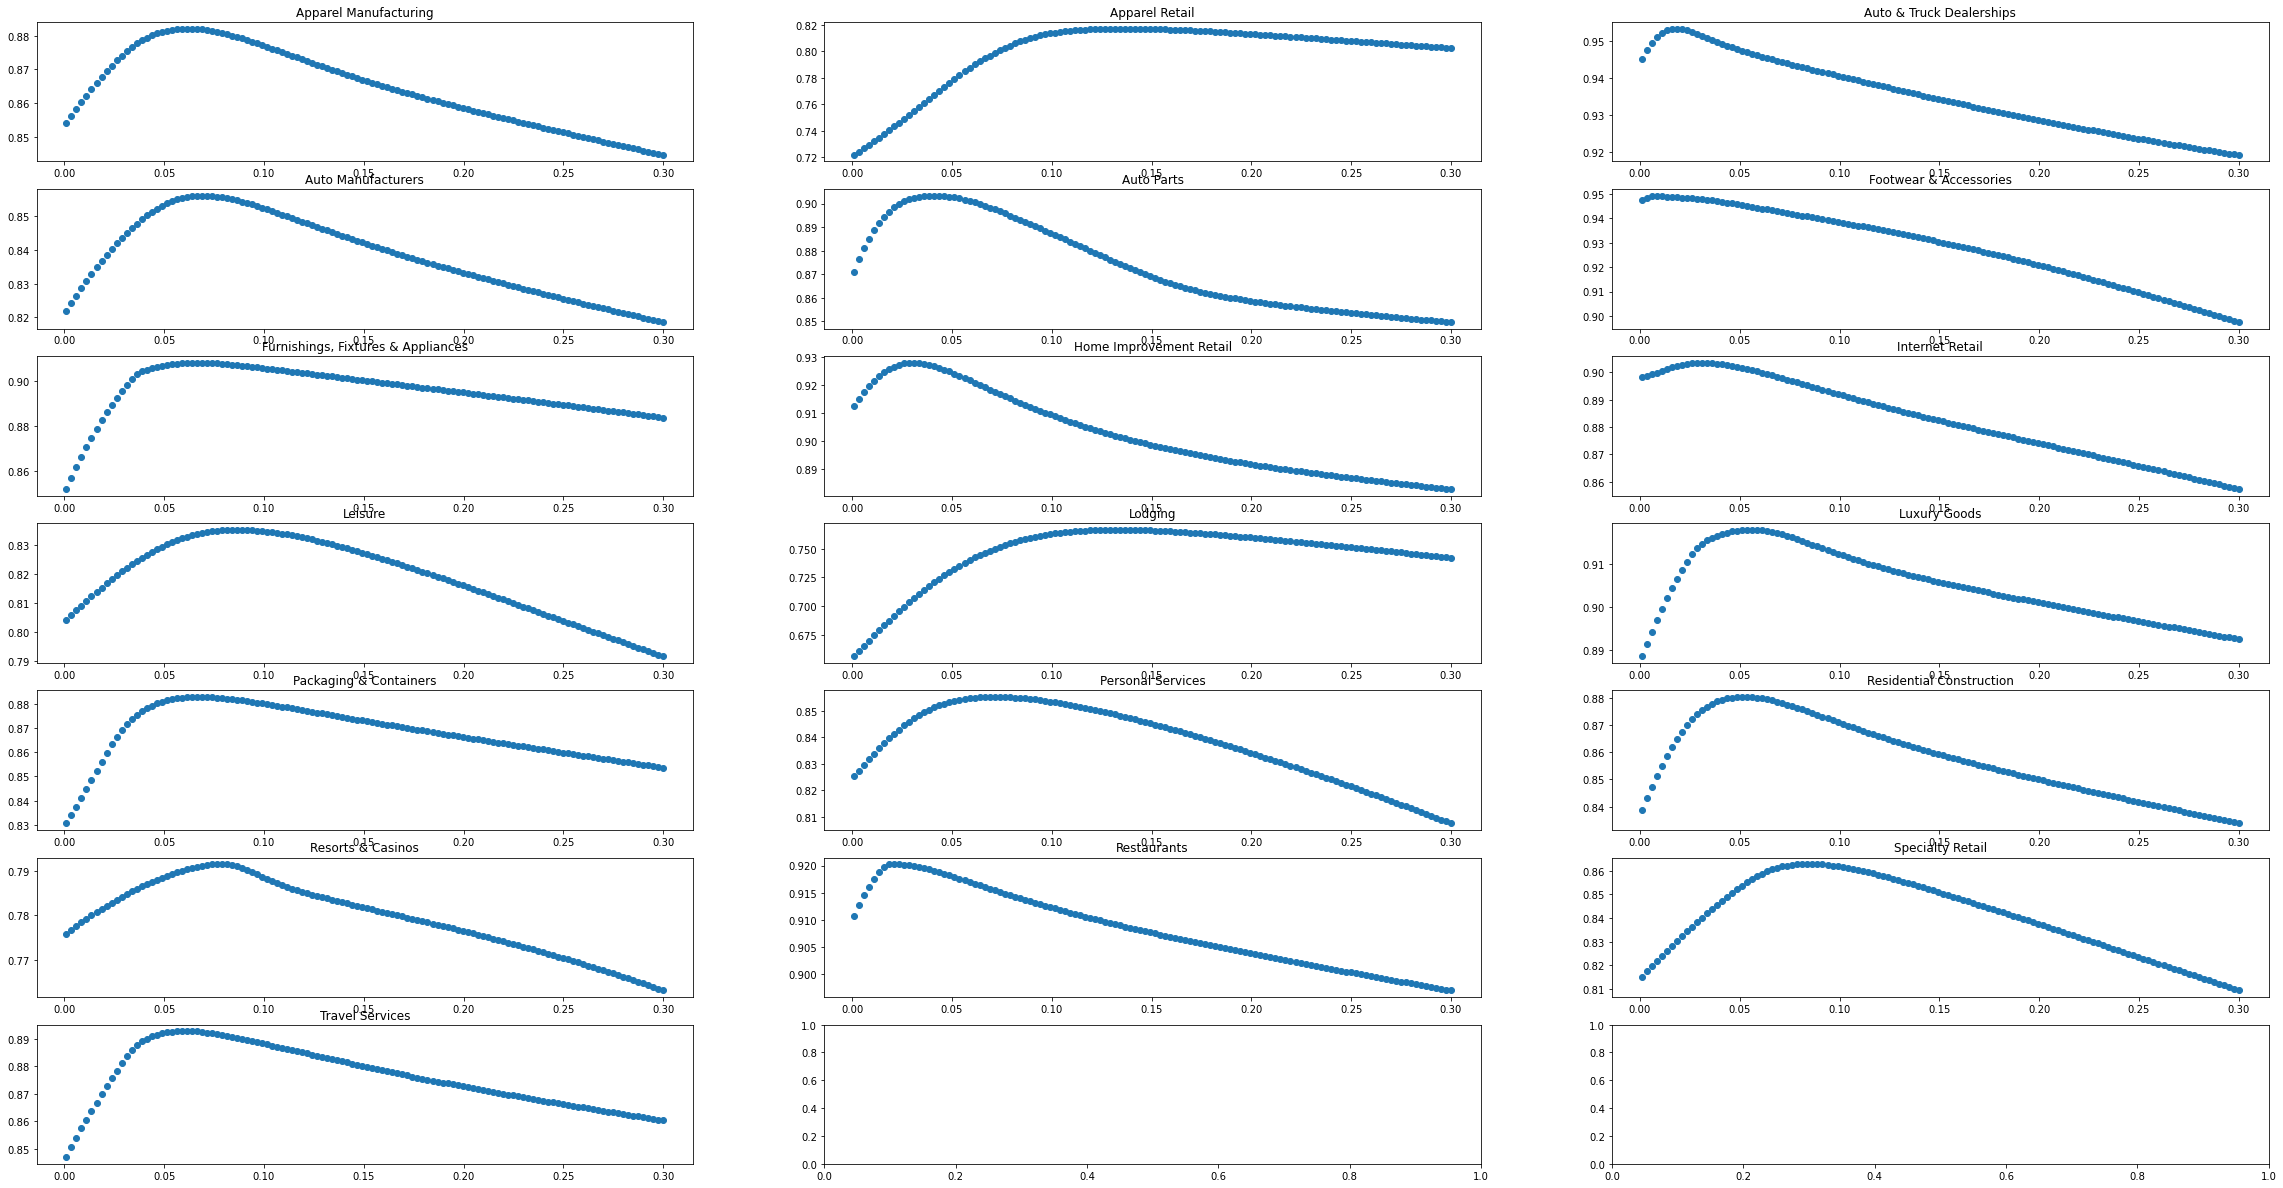

In [228]:
plot_gp_fit_sector(ConsumerCyclical_esg,ConsumerCyclical_esg_index, ConsumerCyclical_gp, ConsumerCyclical_gp_std, ConsumerCyclical_gp_out)
plot_gp_search(ConsumerCyclical_search_out,horizontal_size=3)
ConsumerCyclical_gp.to_pickle('../Yahoo/ConsumerCyclical_gp.pkl')

# Technology

In [229]:
Technology_dict = pd.read_pickle('../Yahoo/Technology_Industry.pkl')
Technology_esg = Technology_dict['data']
Technology_esg_index = Technology_dict['index']
Technology_gp, Technology_gp_std, Technology_gp_out, Technology_search_out = opt_all_col(Technology_esg, Technology_esg_index)

Communication Equipment
{'alpha': 0.12160504201680672}
Computer Hardware
{'alpha': 0.006025210084033613}
Consumer Electronics
{'alpha': 0.021100840336134453}
Electronic Components
{'alpha': 0.08642857142857142}
Information Technology Services
{'alpha': 0.06381512605042017}
Scientific & Technical Instruments
{'alpha': 0.01607563025210084}
Semiconductor Equipment & Materials
{'alpha': 0.07386554621848739}
Semiconductors
{'alpha': 0.026126050420168065}
Software—Application
{'alpha': 0.03115126050420168}
Software—Infrastructure
{'alpha': 0.013563025210084033}


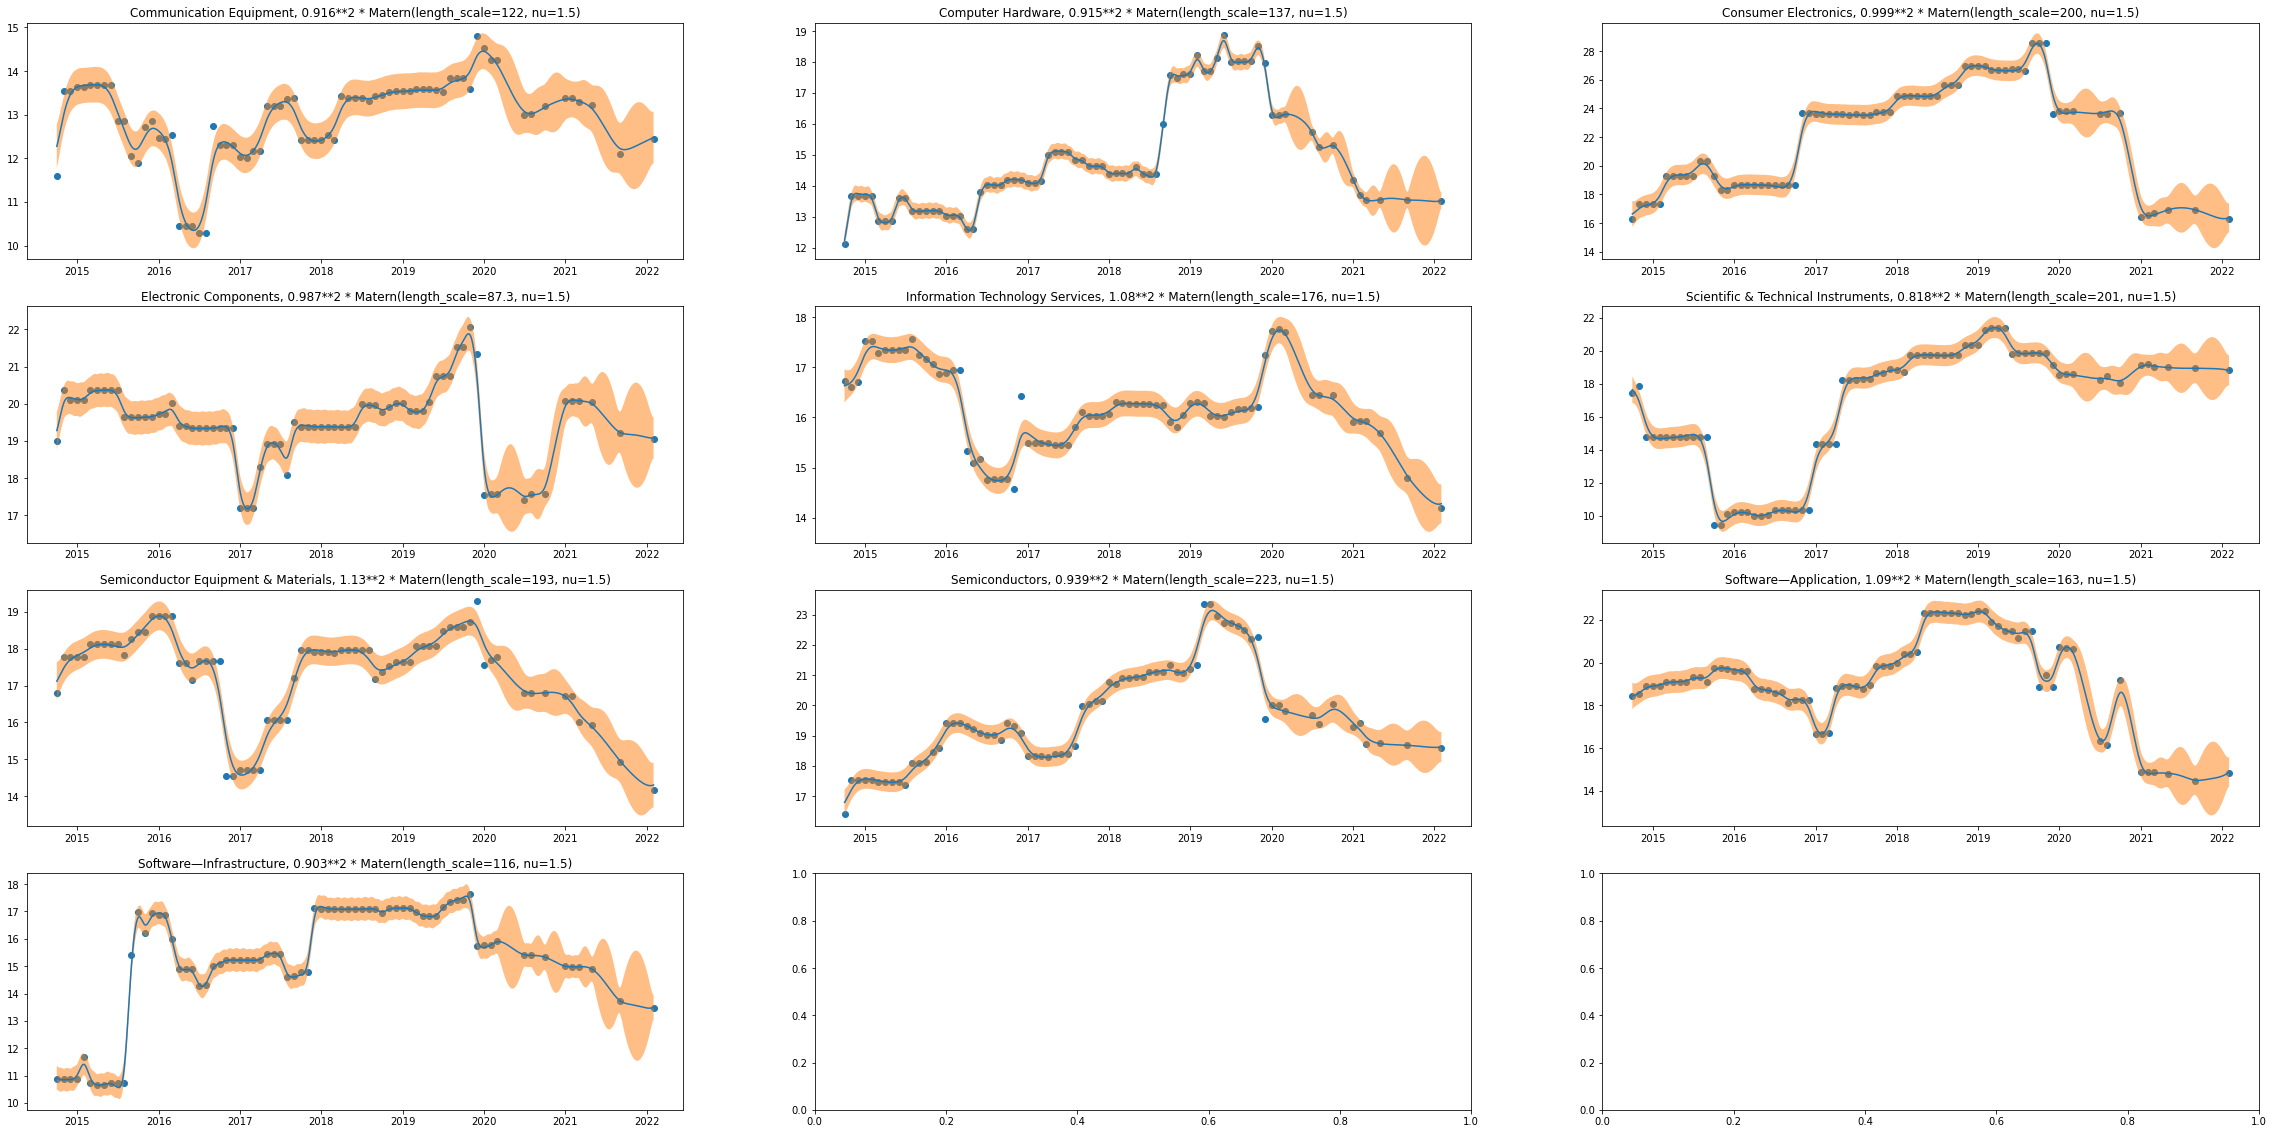

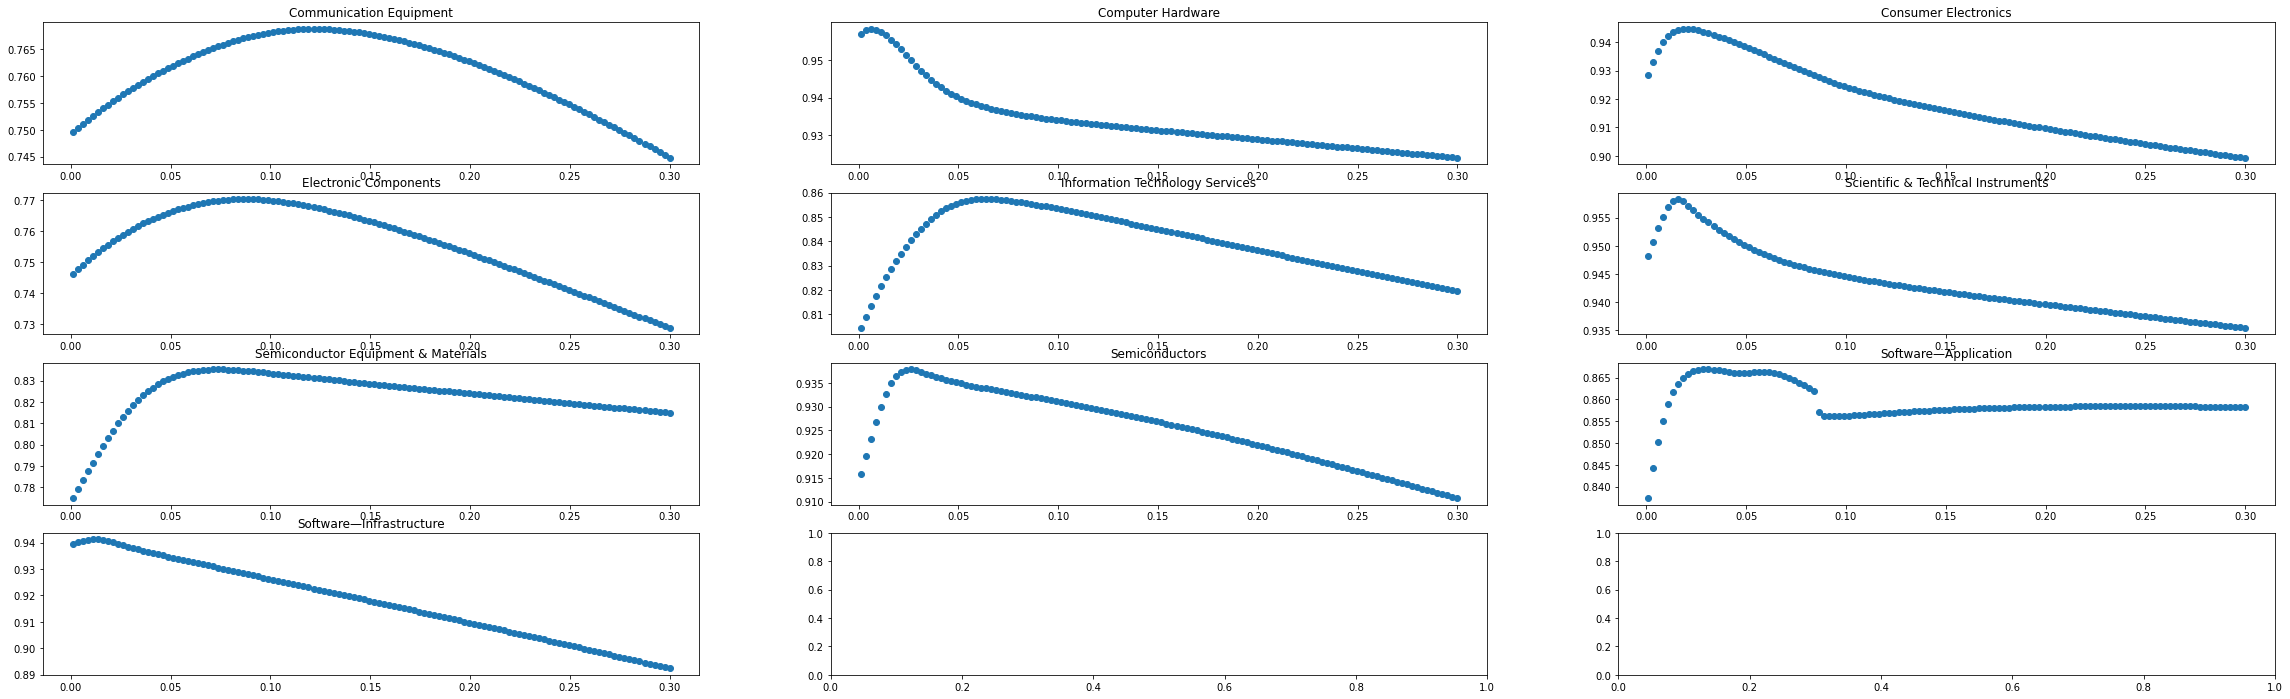

In [230]:
plot_gp_fit_sector(Technology_esg, Technology_esg_index, Technology_gp, Technology_gp_std, Technology_gp_out)
plot_gp_search(Technology_search_out,horizontal_size=3)
Technology_gp.to_pickle('../Yahoo/Technology_gp.pkl')

# Healthcare

In [231]:
Healthcare_dict = pd.read_pickle('../Yahoo/Healthcare_Industry.pkl')
Healthcare_esg = Healthcare_dict['data']
Healthcare_esg_index = Healthcare_dict['index']
Healthcare_gp, Healthcare_gp_std, Healthcare_gp_out, Healthcare_search_out = opt_all_col(Healthcare_esg, Healthcare_esg_index)

Biotechnology
{'alpha': 0.011050420168067225}
Diagnostics & Research
{'alpha': 0.21457142857142855}
Drug Manufacturers—General
{'alpha': 0.011050420168067225}
Drug Manufacturers—Specialty & Generic
{'alpha': 0.12411764705882351}
Health Information Services
{'alpha': 0.02361344537815126}
Healthcare Plans
{'alpha': 0.05125210084033613}
Medical Care Facilities
{'alpha': 0.09145378151260504}
Medical Devices
{'alpha': 0.1140672268907563}
Medical Distribution
{'alpha': 0.10401680672268906}
Medical Instruments & Supplies
{'alpha': 0.03115126050420168}
Pharmaceutical Retailers
{'alpha': 0.03366386554621849}


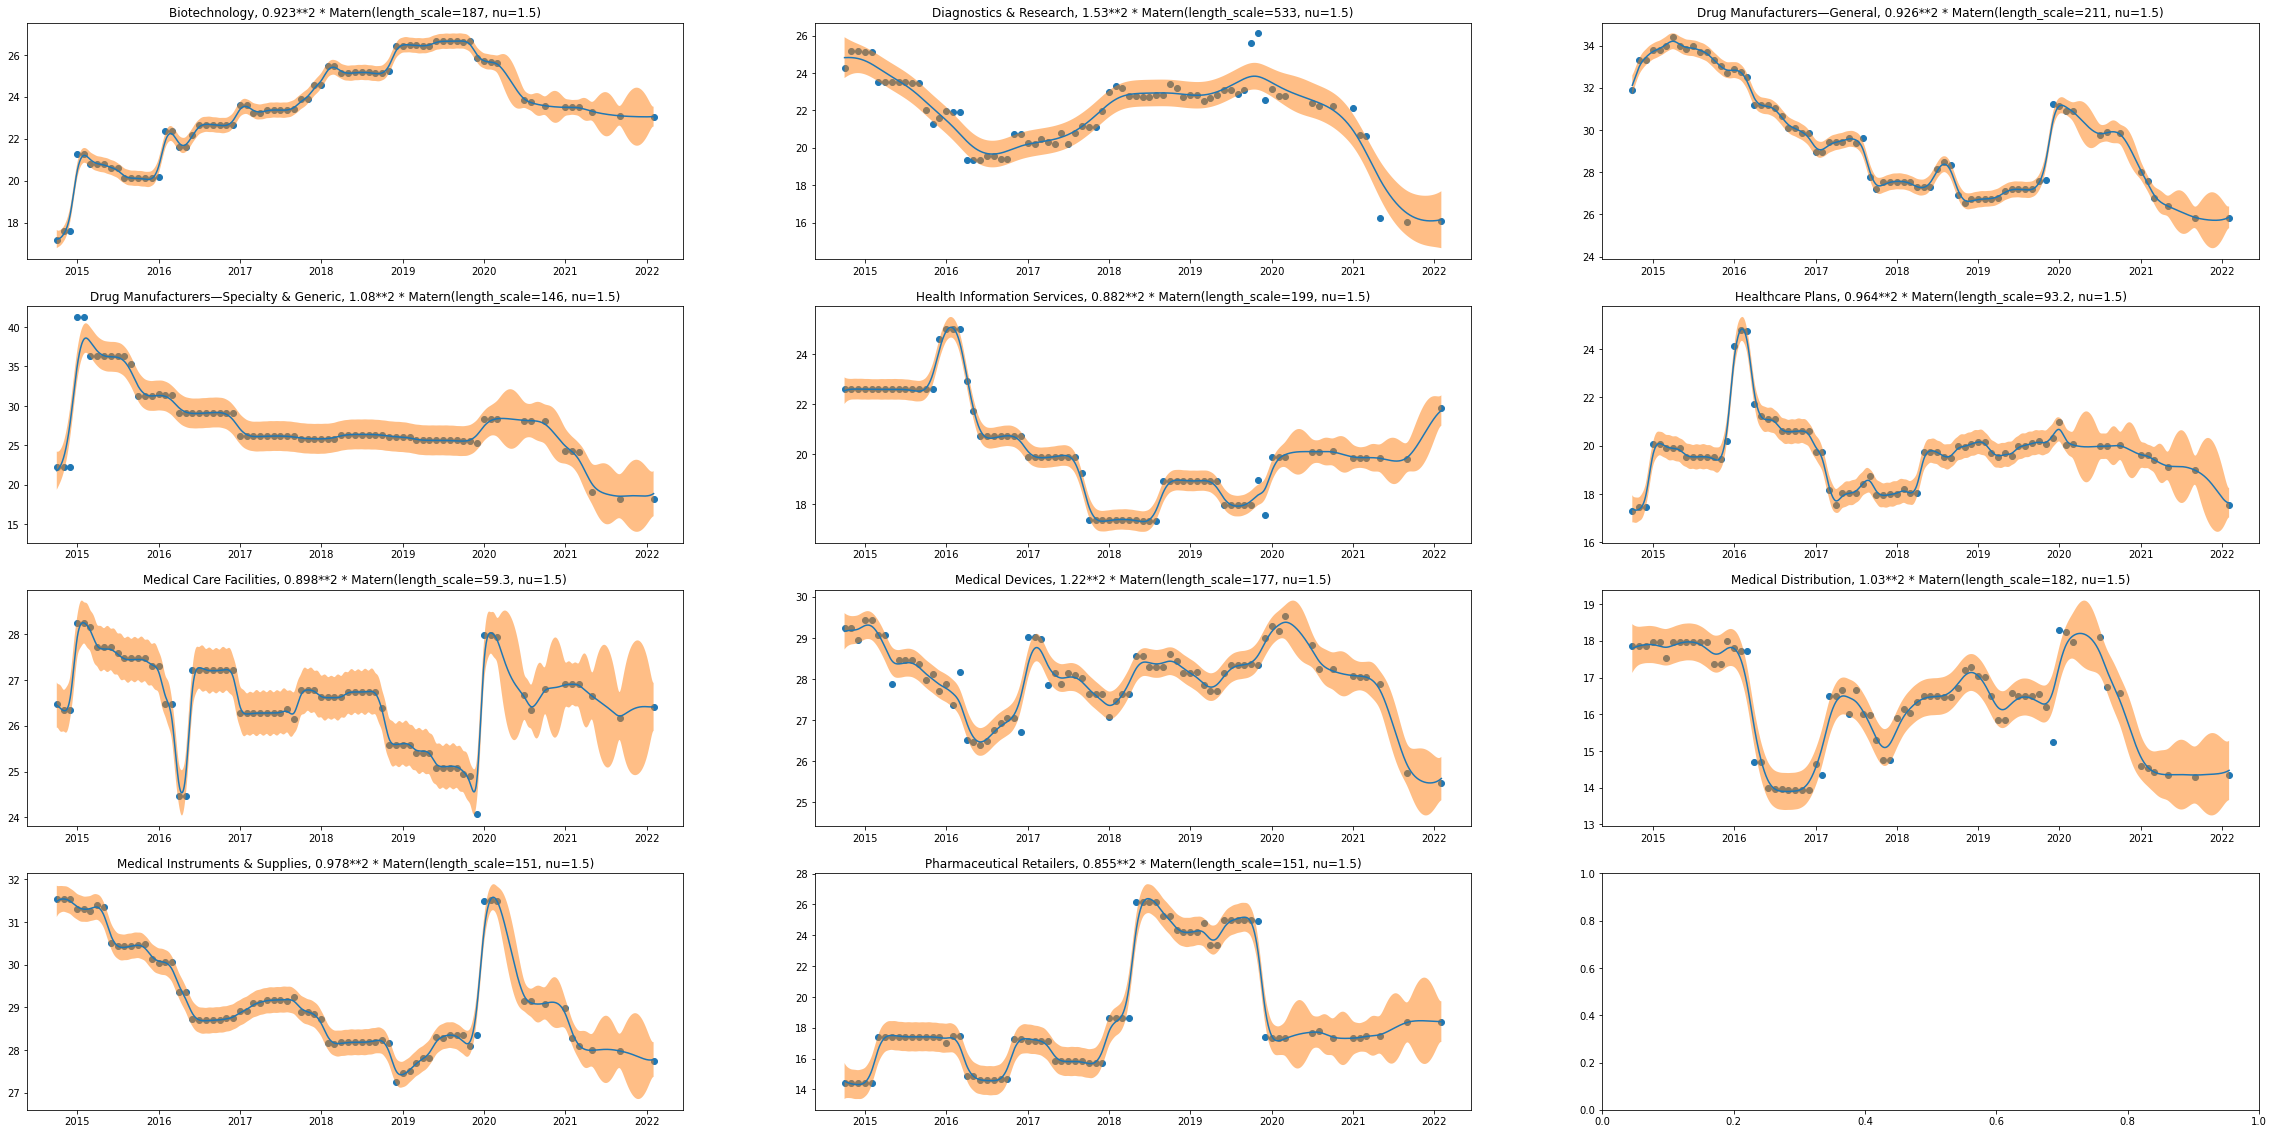

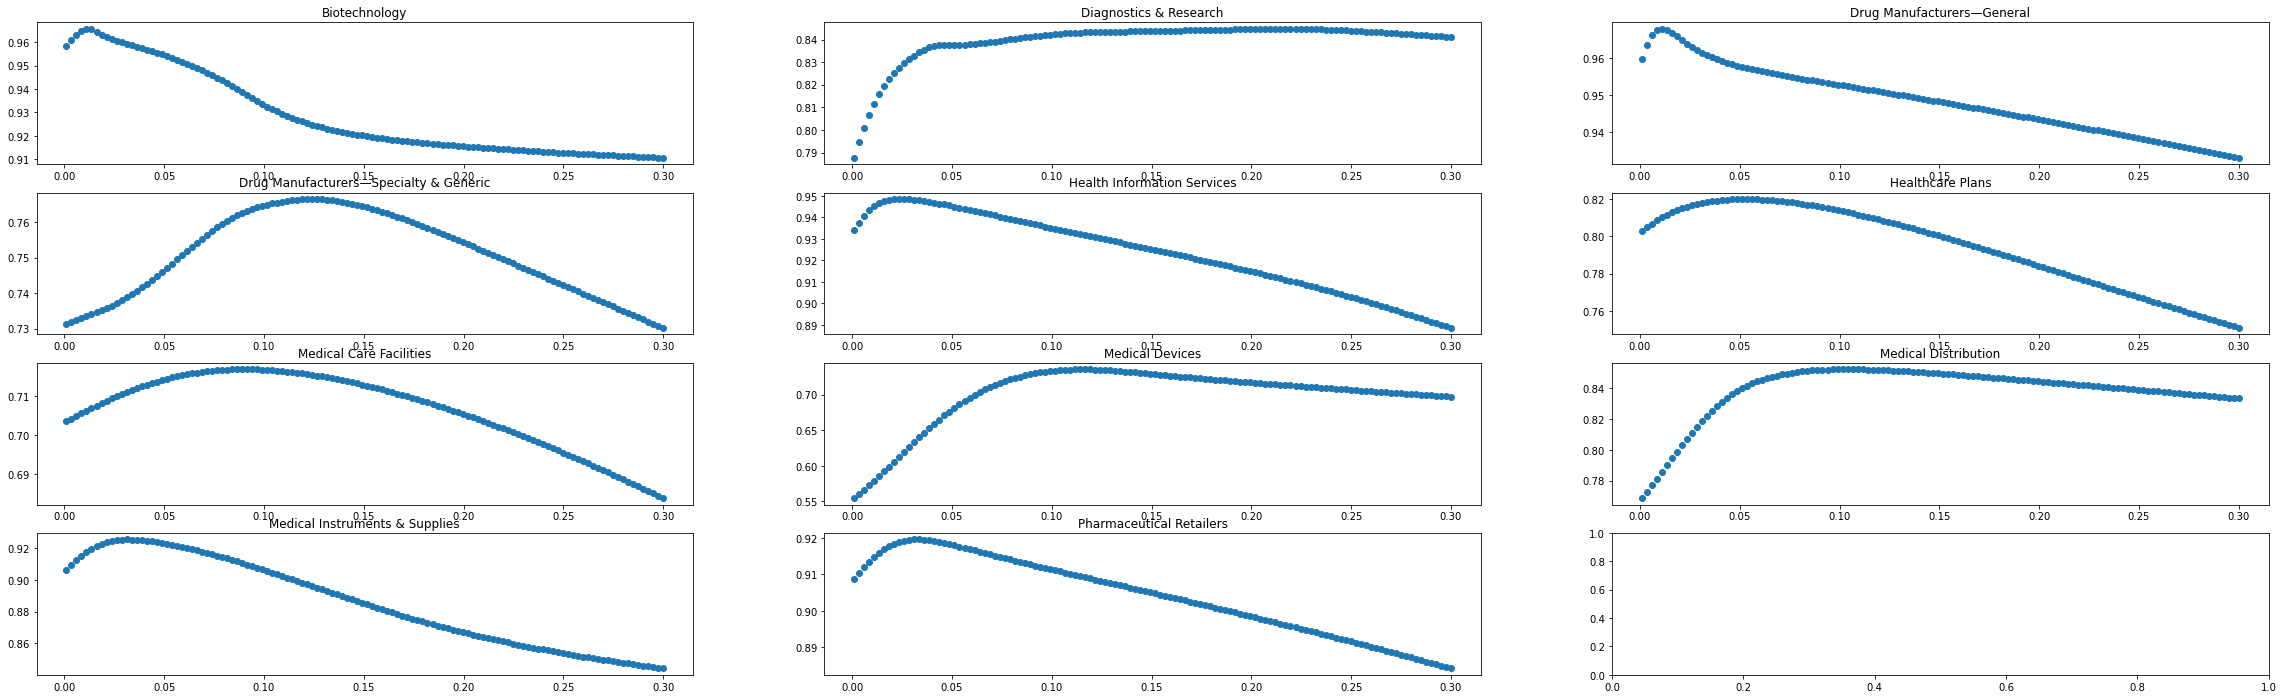

In [232]:
plot_gp_fit_sector(Healthcare_esg, Healthcare_esg_index, Healthcare_gp, Healthcare_gp_std, Healthcare_gp_out)
plot_gp_search(Healthcare_search_out,horizontal_size=3)
Healthcare_gp.to_pickle('../Yahoo/Healthcare_gp.pkl')

# Real Estate

In [233]:
RealEstate_dict = pd.read_pickle('../Yahoo/RealEstate_Industry.pkl')
RealEstate_esg = RealEstate_dict['data']
RealEstate_esg_index = RealEstate_dict['index']
RealEstate_gp, RealEstate_gp_std, RealEstate_gp_out, RealEstate_search_out = opt_all_col(RealEstate_esg, RealEstate_esg_index)

REIT—Healthcare Facilities
{'alpha': 0.041201680672268905}
REIT—Hotel & Motel
{'alpha': 0.12914285714285714}
REIT—Industrial
{'alpha': 0.041201680672268905}
REIT—Office
{'alpha': 0.001}
REIT—Residential
{'alpha': 0.00853781512605042}
REIT—Retail
{'alpha': 0.05125210084033613}
REIT—Specialty
{'alpha': 0.021100840336134453}
Real Estate Services
{'alpha': 0.04371428571428571}


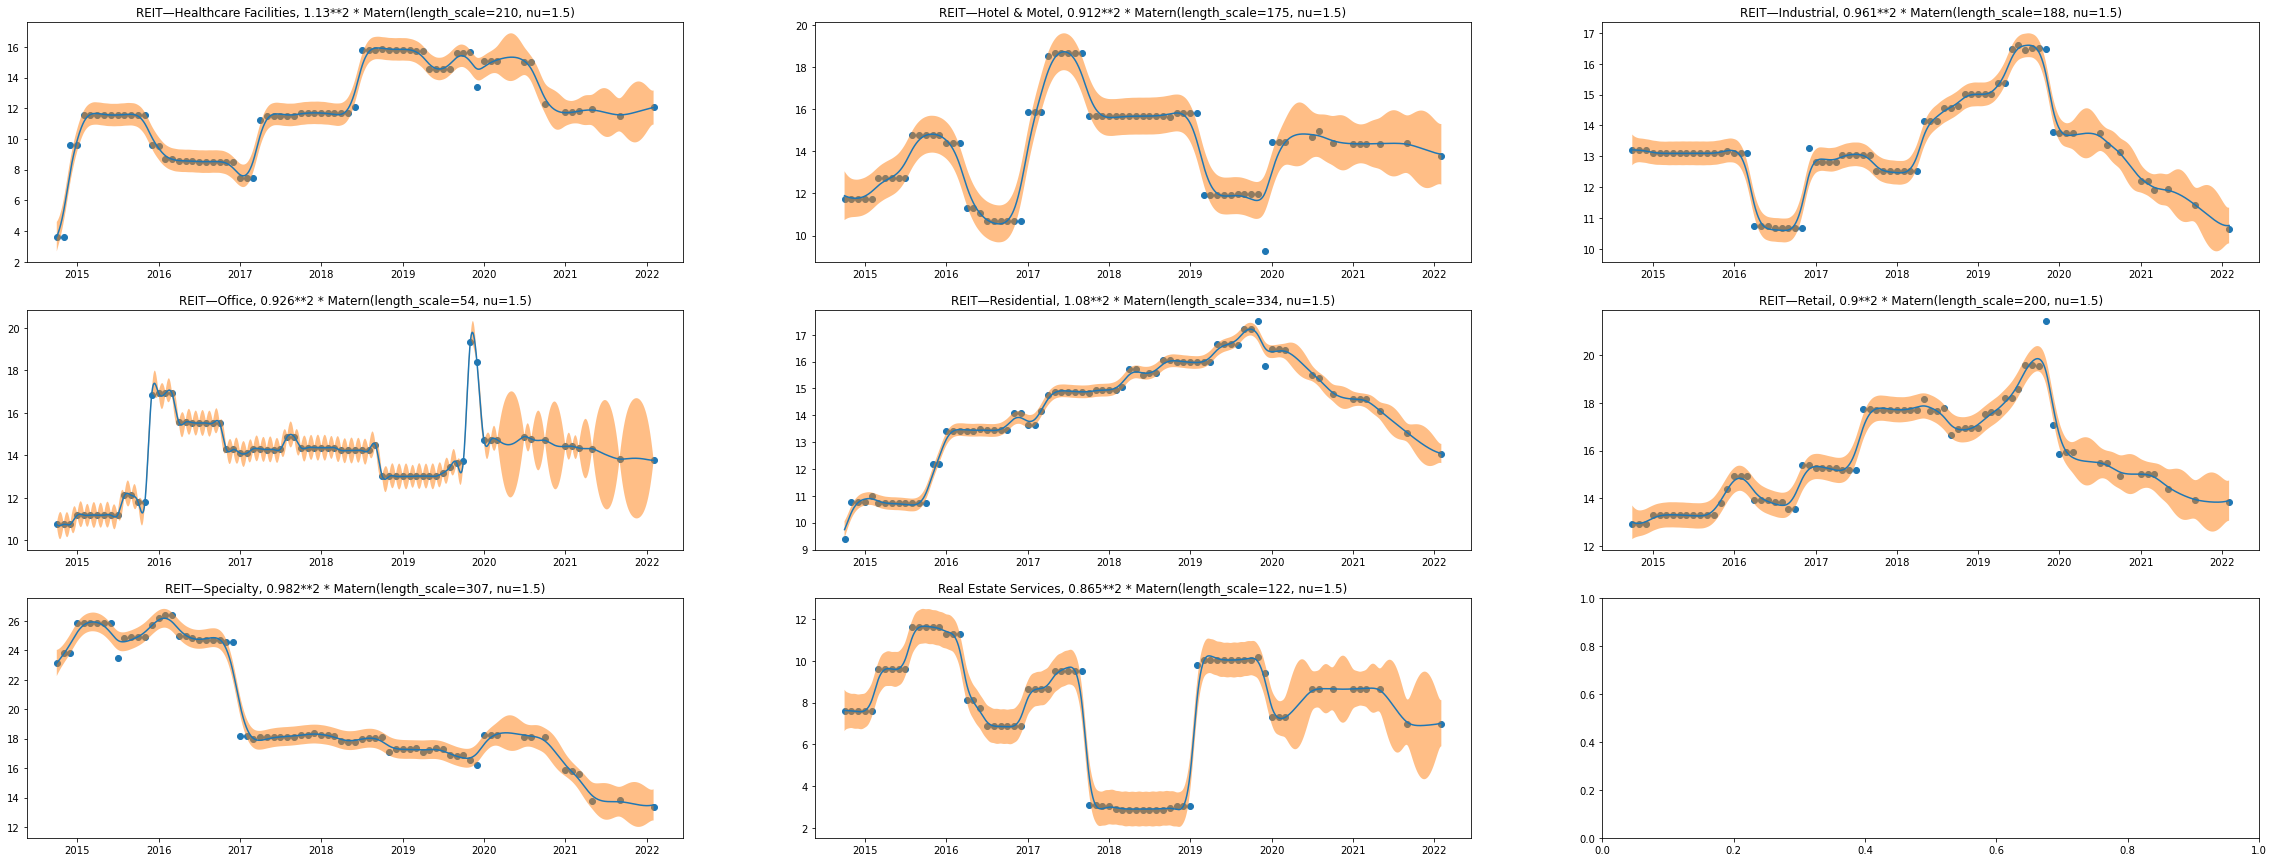

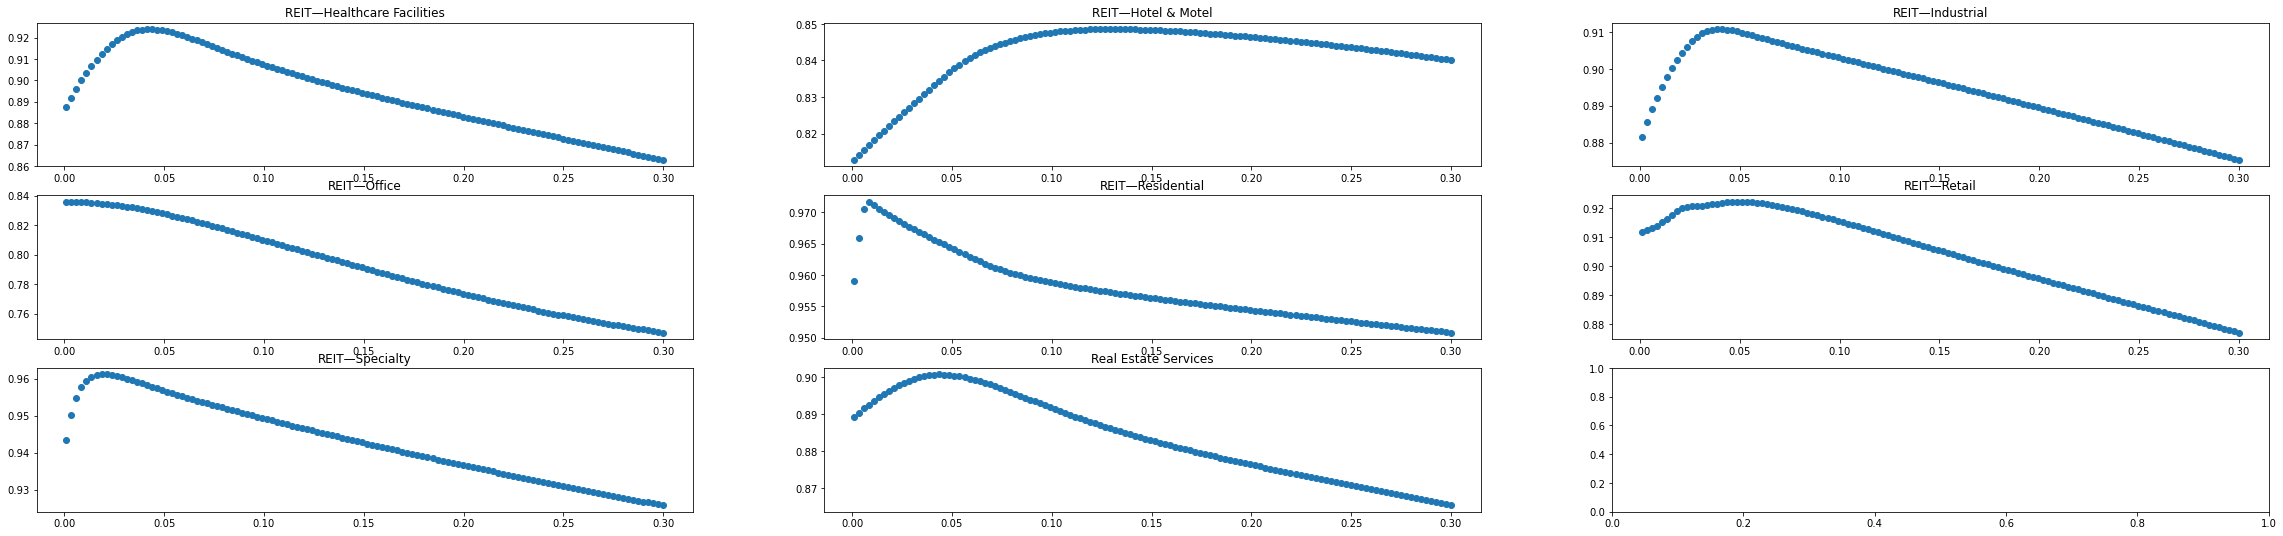

In [234]:
plot_gp_fit_sector(RealEstate_esg, RealEstate_esg_index, RealEstate_gp, RealEstate_gp_std, RealEstate_gp_out)
plot_gp_search(RealEstate_search_out,horizontal_size=3)
RealEstate_gp.to_pickle('../Yahoo/RealEstate_gp.pkl')

# Communication Services

In [235]:
CommunicationServices_dict = pd.read_pickle('../Yahoo/CommunicationServices_Industry.pkl')
CommunicationServices_esg = CommunicationServices_dict['data']
CommunicationServices_esg_index = CommunicationServices_dict['index']
CommunicationServices_gp, CommunicationServices_gp_std, CommunicationServices_gp_out, CommunicationServices_search_out = opt_all_col(CommunicationServices_esg, CommunicationServices_esg_index)

Advertising Agencies
{'alpha': 0.08391596638655462}
Broadcasting
{'alpha': 0.02361344537815126}
Electronic Gaming & Multimedia
{'alpha': 0.04622689075630252}
Entertainment
{'alpha': 0.028638655462184873}
Internet Content & Information
{'alpha': 0.02361344537815126}
Telecom Services
{'alpha': 0.018588235294117645}


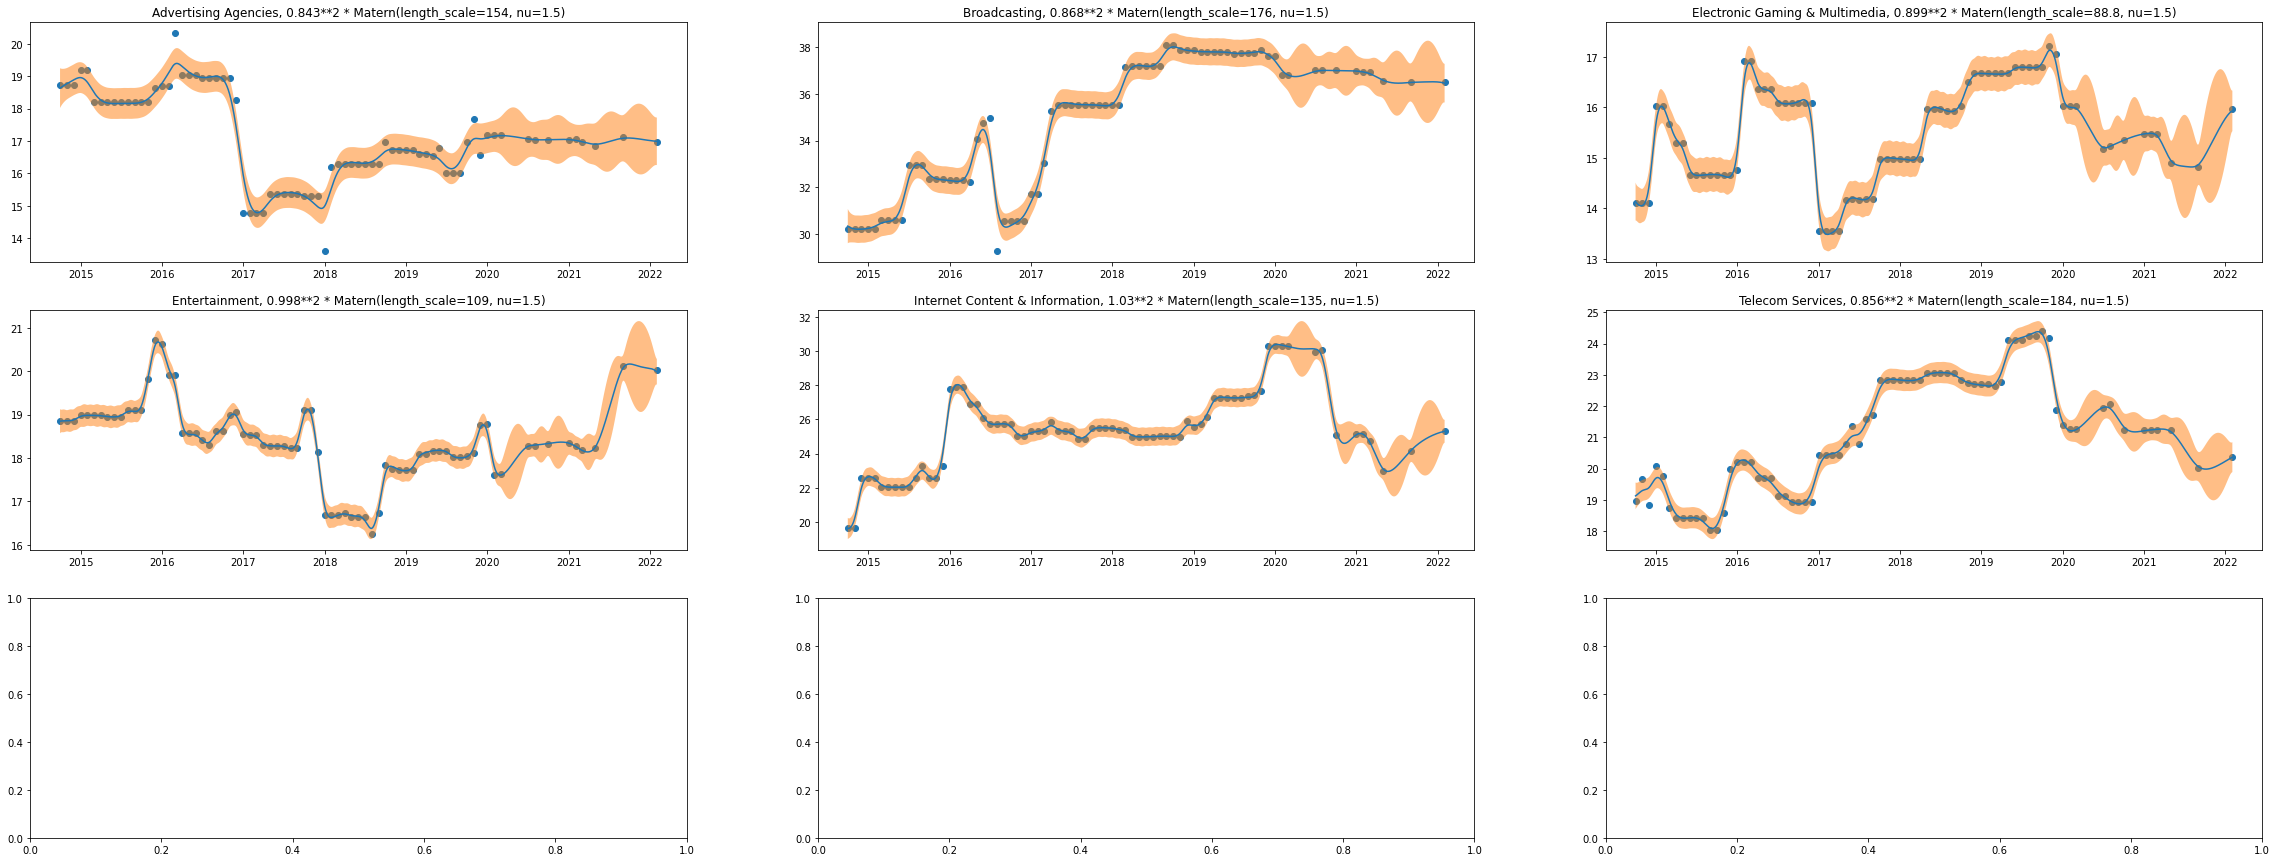

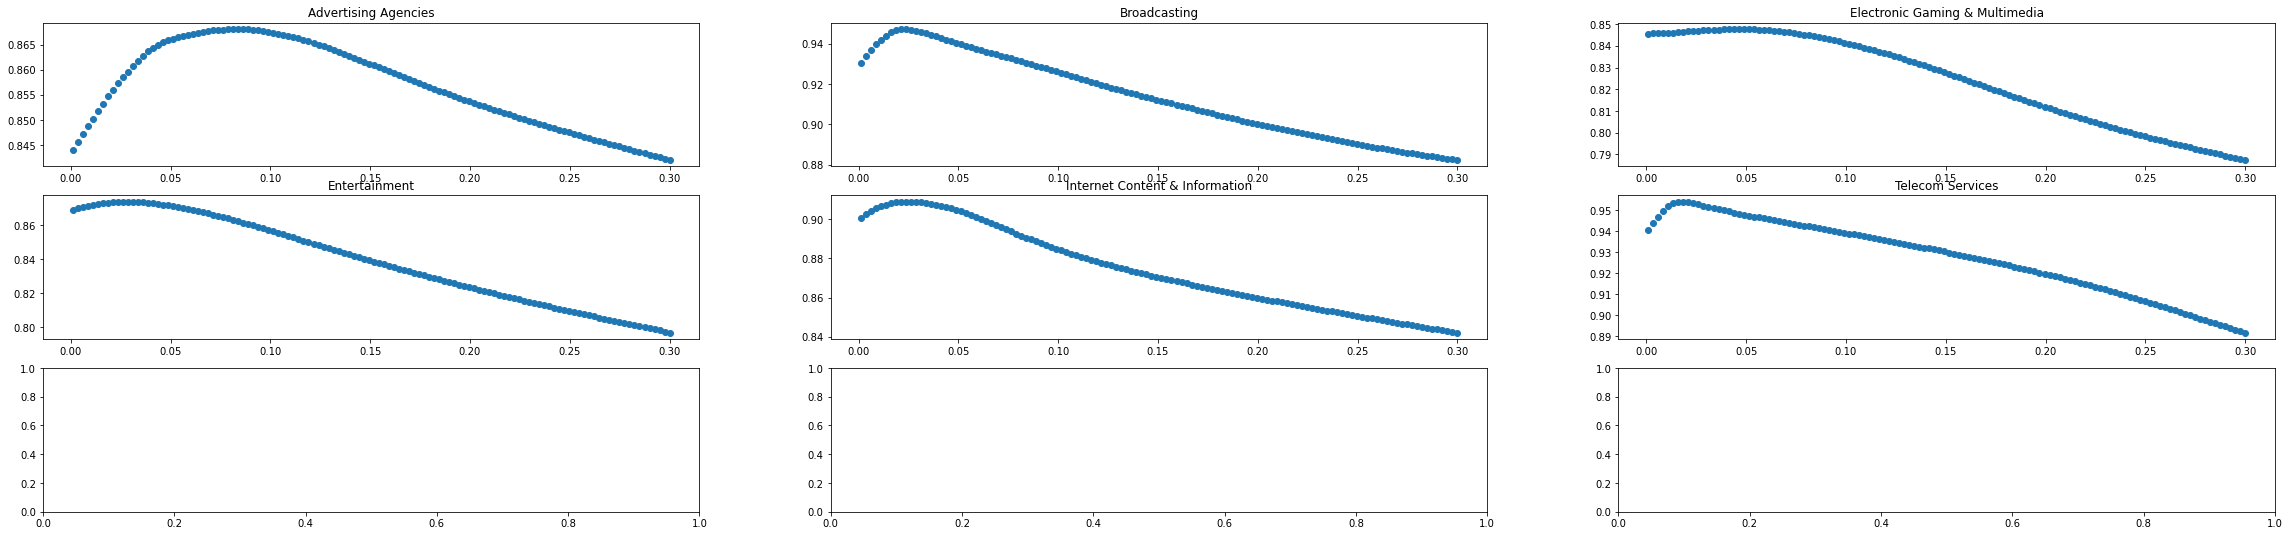

In [236]:
plot_gp_fit_sector(CommunicationServices_esg, CommunicationServices_esg_index, CommunicationServices_gp, CommunicationServices_gp_std, CommunicationServices_gp_out)
plot_gp_search(CommunicationServices_search_out,horizontal_size=3)
CommunicationServices_gp.to_pickle('../Yahoo/CommunicationServices_gp.pkl')

# Differenced

We can look at the differenced series as well

In [12]:
fit_and_print(kernel_tests, X_obs_diff, y_obs_diff)

Matern(length_scale=343, nu=0.5) -37.977412860414326
Matern(length_scale=67.6, nu=1.5) -49.21489964416211
Matern(length_scale=49.8, nu=2.5) -52.033224183048546
RBF(length_scale=32.4) -56.08383680737647
0.326**2 * Matern(length_scale=12.9, nu=0.5) -21.72372936202992
0.326**2 * Matern(length_scale=13.6, nu=1.5) -21.714049740019583
0.326**2 * Matern(length_scale=13.8, nu=2.5) -21.709911267881324
0.326**2 * RBF(length_scale=14.4) -21.69864195512058


C:\Users\User\Code\MMDGraph\.mmdvenv\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


RationalQuadratic(alpha=0.00288, length_scale=1e-05) -24.90674106866193
0.326**2 * RationalQuadratic(alpha=1e+05, length_scale=14.4) -21.69864237179408


C:\Users\User\Code\MMDGraph\.mmdvenv\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Gives lower log likelihood. Including Scale does seems to same value for all kernels. Let's look at a kernel with and without scaling

0.372**2 * ExpSineSquared(length_scale=0.000855, periodicity=1.18)


C:\Users\User\Code\MMDGraph\.mmdvenv\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


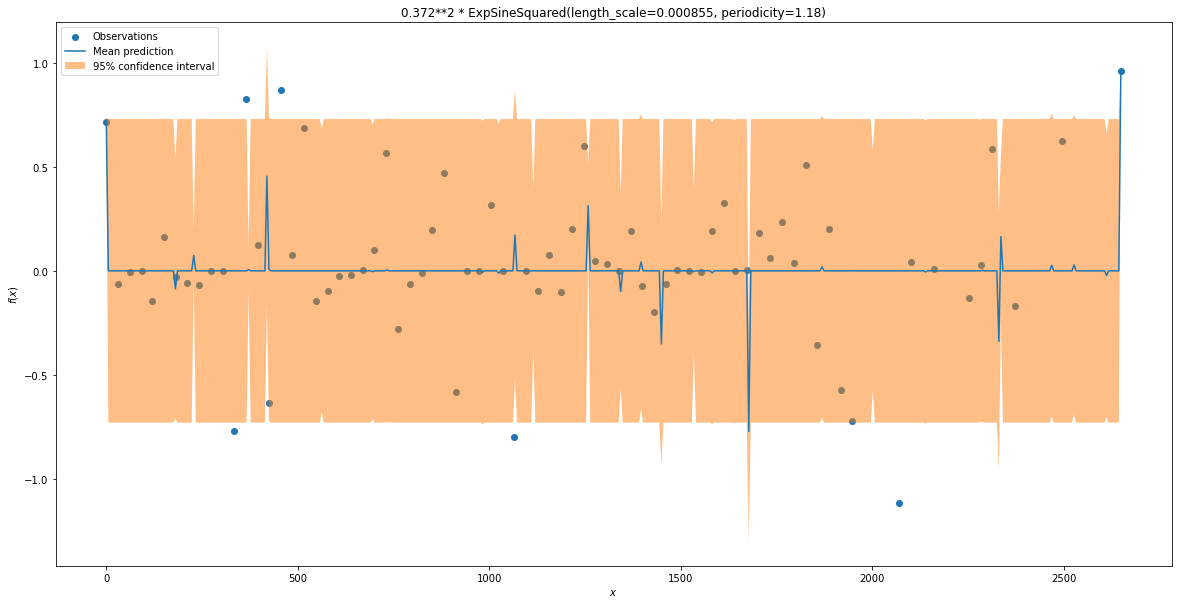

In [248]:
gp = gaussian_process.GaussianProcessRegressor(kernel=1*ExpSineSquared(length_scale=1, periodicity = 1), n_restarts_optimizer=10, alpha = 0.0001).fit(X_obs_diff, y_obs_diff)
print(gp.kernel_)
plot_fit(gp, X_obs_diff, y_obs_diff)

Matern(length_scale=54.2, nu=1.5)


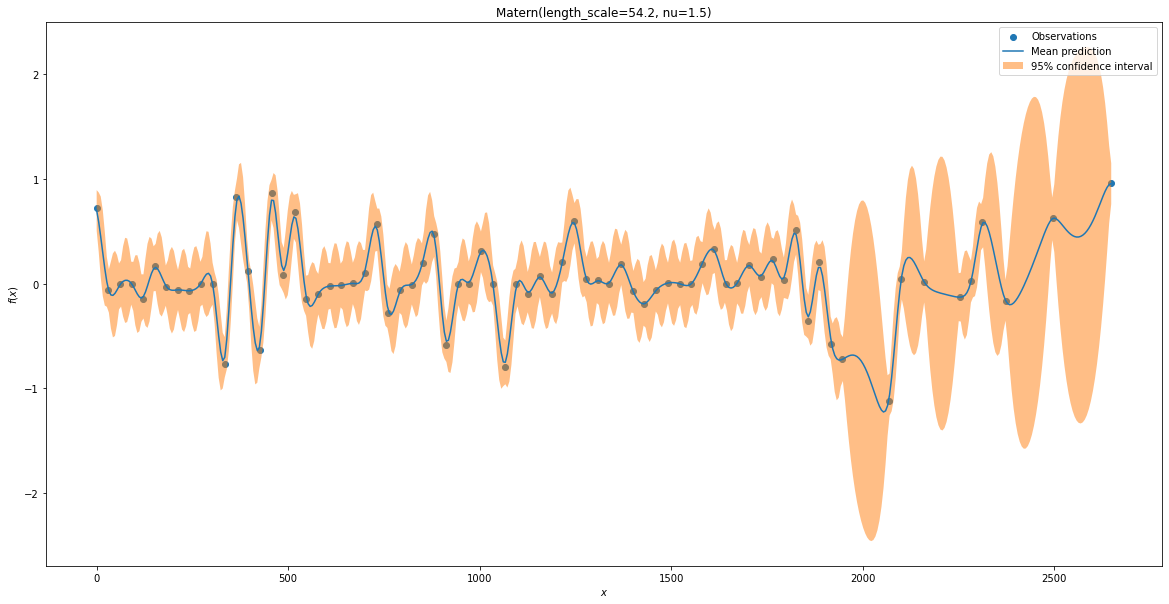

In [257]:
gp = gaussian_process.GaussianProcessRegressor(kernel=Matern(length_scale=1, nu = 1.5), n_restarts_optimizer=50, alpha = 0.01).fit(X_obs_diff, y_obs_diff)
print(gp.kernel_)
plot_fit(gp, X_obs_diff, y_obs_diff)

Matern with $\nu = 0.5$ is basically linear interpolation

Matern(length_scale=67.6, nu=1.5)
-49.2148996441621


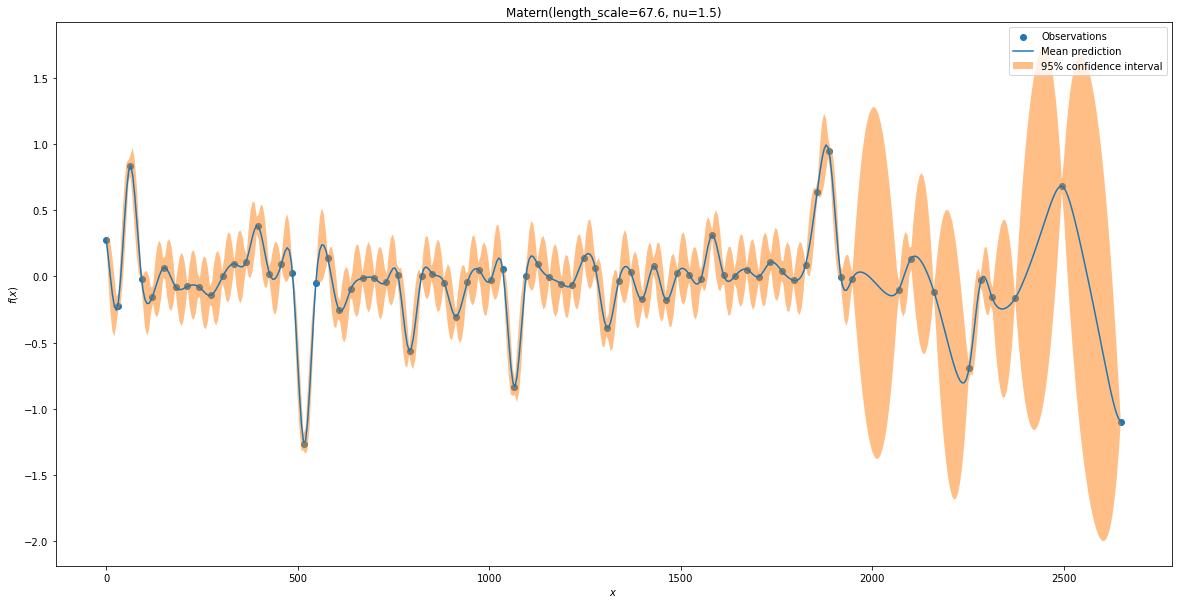

In [15]:
gp = gaussian_process.GaussianProcessRegressor(kernel=Matern(length_scale=1, nu = 1.5)  , n_restarts_optimizer=50).fit(X_obs_diff, y_obs_diff)
print(gp.kernel_)
print(gp.log_marginal_likelihood_value_)
plot_fit(gp, X_obs_diff, y_obs_diff)

RBF(length_scale=32.4)
-56.08383680737648


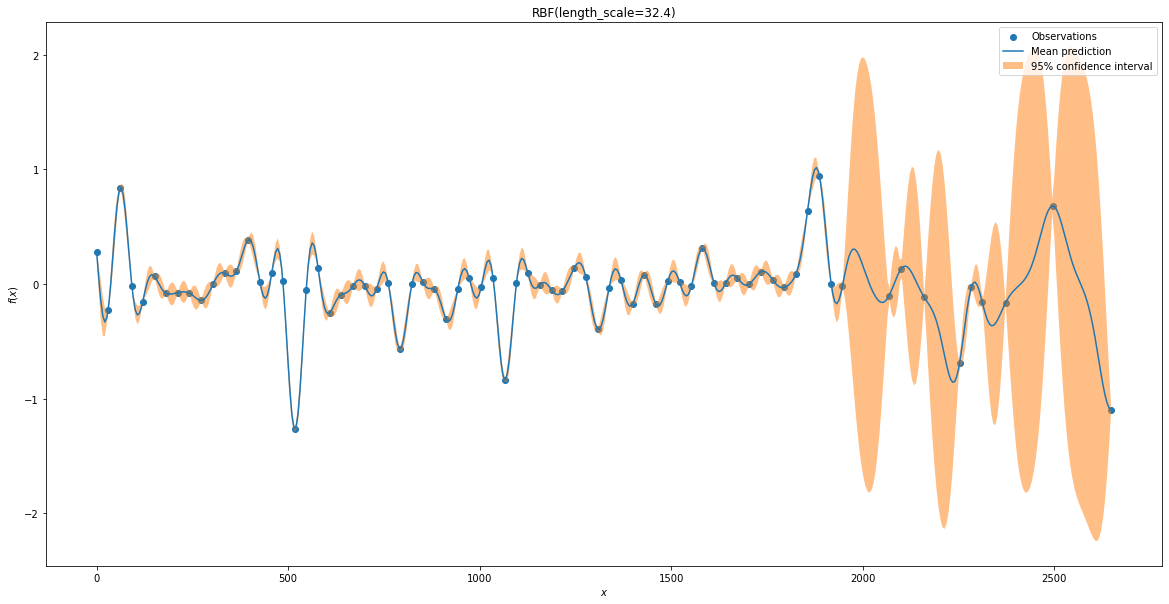

In [19]:
gp = gaussian_process.GaussianProcessRegressor(kernel=RBF(length_scale=1), n_restarts_optimizer=50).fit(X_obs_diff, y_obs_diff)
print(gp.kernel_)
print(gp.log_marginal_likelihood_value_)
plot_fit(gp, X_obs_diff, y_obs_diff)

0.372**2 * Matern(length_scale=1e-05, nu=1.5)
-31.882091882043206


C:\Users\User\Code\MMDGraph\.mmdvenv\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


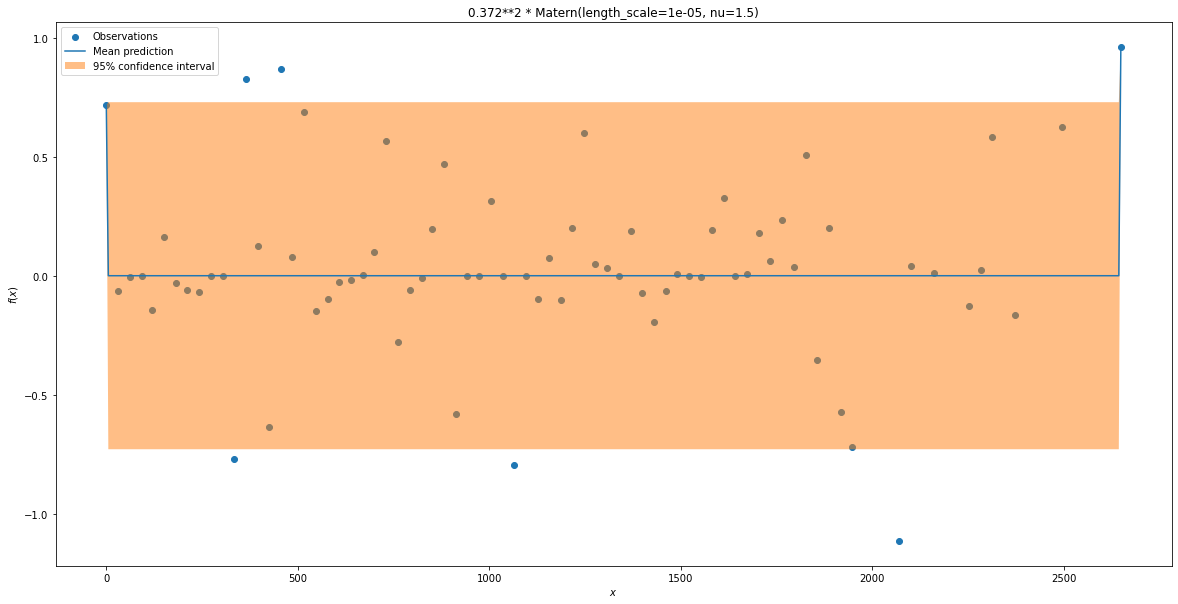

In [236]:
gp = gaussian_process.GaussianProcessRegressor(kernel=1*Matern(length_scale=1, nu = 1.5), alpha = 0.00000001  , n_restarts_optimizer=5).fit(X_obs_diff, y_obs_diff)
print(gp.kernel_)
print(gp.log_marginal_likelihood_value_)
plot_fit(gp, X_obs_diff, y_obs_diff)

# ESG companies

In [ ]:
esg_diff = pd.read_pickle('../Yahoo/refined.pkl')
esg = pd.read_pickle('../Yahoo/refined_no_diff.pkl')
company = 'ABBV'
y_company_diff = np.array(esg_diff[company])
y_company_diff = y_company_diff[np.isfinite(y_company_diff)]
x_company_diff = np.expand_dims(np.array(range(len(y_company_diff))), axis = 1)

y_company = np.array(esg[company])
y_company = y_company[np.isfinite(y_company)]
x_company = np.expand_dims(np.array(range(len(y_company))), axis = 1)


Matern(length_scale=1e-05, nu=1.5)
-97.9713655266504


C:\Users\User\Code\MMDGraph\.mmdvenv\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


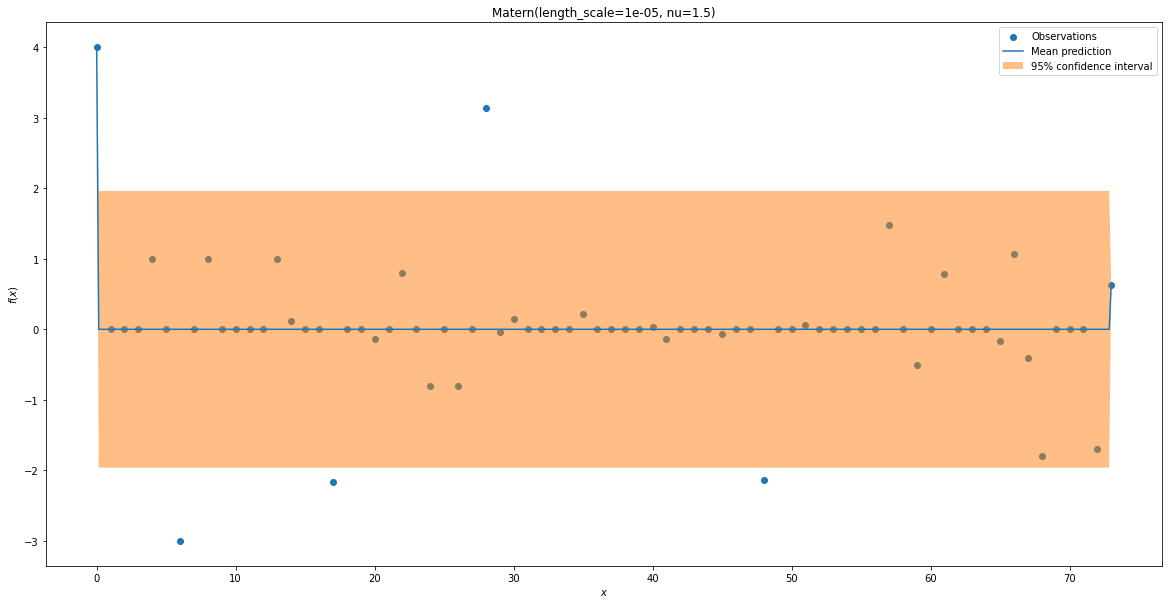

In [ ]:
gp = gaussian_process.GaussianProcessRegressor(kernel=Matern(length_scale=1, nu = 1.5), n_restarts_optimizer=5).fit(x_company_diff, y_company_diff)
print(gp.kernel_)
print(gp.log_marginal_likelihood_value_)
plot_fit(gp, x_company_diff, y_company_diff)

Matern(length_scale=16.4, nu=1.5)
-2314.463193723079


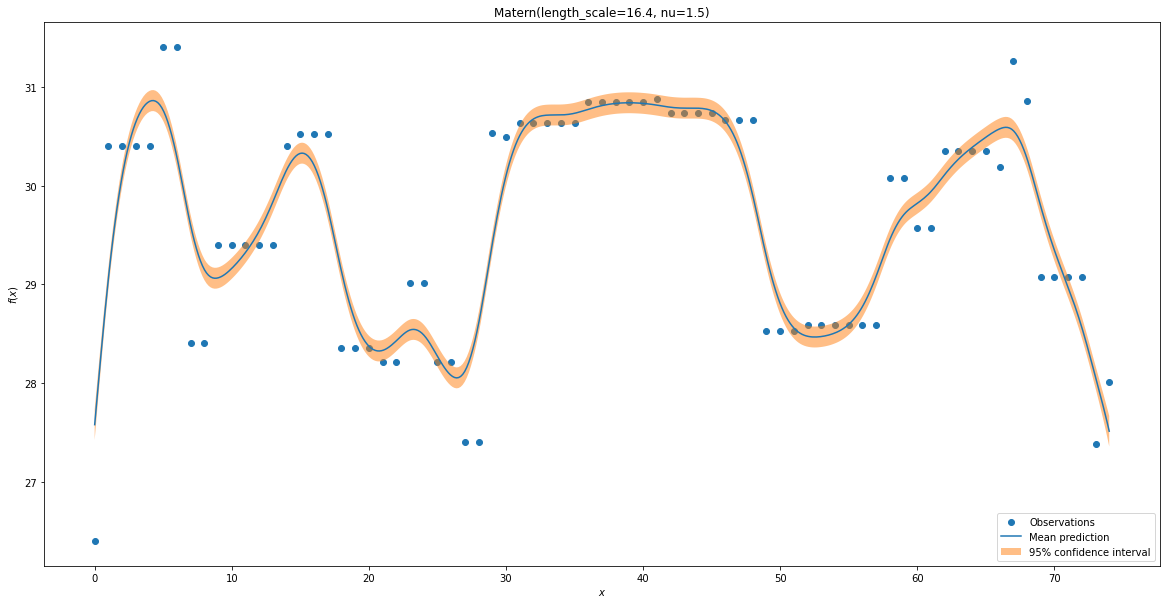

In [ ]:
gp = gaussian_process.GaussianProcessRegressor(kernel=Matern(length_scale=1, nu = 1.5), n_restarts_optimizer=5, alpha= 0.01).fit(x_company, y_company)
print(gp.kernel_)
print(gp.log_marginal_likelihood_value_)
plot_fit(gp, x_company, y_company)

sector_esg_diff = pd.read_pickle('../Yahoo/sector_index.pkl')